In [68]:
import pandas as pd
import numpy as np
import time
from collections import Counter
import pickle as pkl

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GaussianNoise, Conv1D , GRU
from tensorflow.keras.layers import Dropout, Concatenate, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from tensorflow.python.keras.utils import plot_model
from tqdm import tqdm
from scipy import stats
from collections import Counter
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))
    
def MAE(y_te, pred):
    return np.round(mean_absolute_error(y_te, pred), decimals=4)

def ans_process(x):
    return np.maximum(np.array([i[0]//10*10 for i in x]), 0).round(0).astype(np.int)

In [3]:
target_var = ['Target_Hb']

info_vars = ['Study_Subject_Number', 'Order'] 

categoryA = ["Hemoglobin[Whole blood]", "Delta_Hb", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars + target_var

In [4]:
temp = pd.read_excel("Anemia_Mean.xlsx", sheet_name=0, header=0)
indexes = np.unique(temp['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [temp['Study_Subject_Number'].values[index] for index in sorted(indexes)]

seed = 0
train_patient, test_patient = train_test_split(patient_list, test_size = 0.2, random_state=seed)
valid_patient, test_patient = train_test_split(test_patient, test_size = 0.5, random_state=seed)

In [5]:
with open('./scaler/trn_scaler_mean_classifier.pkl','rb') as f:
    trn_scaler_mean_classifier = pkl.load(f)
    
with open('./scaler/hb_scaler_mean_classifier.pkl','rb') as f:
    hb_scaler_mean_classifier = pkl.load(f)

with open('./scaler/trn_scaler_mean.pkl','rb') as f:
    trn_scaler_mean = pkl.load(f)
    
with open('./scaler/hb_scaler_mean.pkl','rb') as f:
    hb_scaler_mean = pkl.load(f)

In [6]:
def get_var_index(var_name):
    for i, v in enumerate(trn_vars):
        if var_name == v:
            return i
    return None

In [7]:
hb_idx = get_var_index('Hemoglobin[Whole blood]')
epo_idx = get_var_index('EPO_Dose')

mean_epo = trn_scaler_mean.mean_[epo_idx]
std_epo = np.sqrt(trn_scaler_mean.var_[epo_idx])

mean_hb = trn_scaler_mean.mean_[hb_idx]
std_hb = np.sqrt(trn_scaler_mean.var_[hb_idx])

mean_target_hb = hb_scaler_mean_classifier.mean_[0]
std_target_hb = np.sqrt(hb_scaler_mean_classifier.var_[0])

In [8]:
def transform_epo(x): 
    return (x-mean_epo)/(std_epo)
def inverse_transform_epo(x):
    return np.maximum((std_epo*x+mean_epo).round(0), 0)

def transform_hb(x):
    return (x-mean_hb)/(std_hb)
def inverse_transform_hb(x):
    return (std_hb*x+mean_hb).round(1)

def transform_target_hb(x):
    return (x-mean_target_hb)/(std_target_hb)
def inverse_transform_target_hb(x):
    return (std_target_hb*x+mean_target_hb).round(1)

## Get Best Model

In [9]:
def get_model():        
    inp = Input(shape=(seq_len, len(trn_vars)))
    gauss1 = GaussianNoise(0.1)(inp)
    layer1 = GRU(256, return_sequences=True,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(gauss1)
    layer2 = GRU(64, return_sequences=False,
                recurrent_activation='hard_sigmoid',
                activation='tanh')(layer1)   
    fc = Dense(4)(layer2)
    outp = Dense(1)(fc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss = 'mean_absolute_error', 
                  optimizer=Adam(0.001),
                  metrics=['mean_absolute_error'])
    return model

seq_len = 6

with open('./data/mean_{}.pkl'.format(seq_len),'rb') as f:
    loaded_data = pkl.load(f)
[[x_train,y_train,train_data_info],[x_valid,y_valid,valid_data_info],[x_test,y_test,test_data_info]] = loaded_data

model = get_model()
model.load_weights('./model/gru_mean_{}.h5'.format(seq_len))

print(seq_len)
pred_train = model.predict(x_train)
print('train')
y_train_modified = hb_scaler_mean_classifier.inverse_transform(y_train)
pred_train = hb_scaler_mean_classifier.inverse_transform(pred_train)
evaluate(y_train_modified, pred_train)

pred_valid = model.predict(x_valid)
print('val')
y_valid_modified = hb_scaler_mean_classifier.inverse_transform(y_valid)
pred_valid = hb_scaler_mean_classifier.inverse_transform(pred_valid)
evaluate(y_valid_modified, pred_valid)

pred_test = model.predict(x_test)
print('test')
y_test_modified = hb_scaler_mean_classifier.inverse_transform(y_test)
pred_test = hb_scaler_mean_classifier.inverse_transform(pred_test)
evaluate(y_test_modified, pred_test)

6
train
mae: 0.5483
rmse: 0.7259
me: 0.0163
val
mae: 0.5908
rmse: 0.7665
me: 0.0221
test
mae: 0.5985
rmse: 0.7789
me: 0.0129


In [10]:
# 6
# train
# mae: 0.5483
# rmse: 0.7259
# me: 0.0163
# val
# mae: 0.5908
# rmse: 0.7665
# me: 0.0221
# test
# mae: 0.5985
# rmse: 0.7789
# me: 0.0129

In [11]:
x_train_modified = x_train.copy()
x_valid_modified = x_valid.copy()
x_test_modified = x_test.copy()

x_train_modified[:,:,epo_idx] = inverse_transform_epo(x_train_modified[:,:,epo_idx])
x_valid_modified[:,:,epo_idx] = inverse_transform_epo(x_valid_modified[:,:,epo_idx])
x_test_modified[:,:,epo_idx] = inverse_transform_epo(x_test_modified[:,:,epo_idx])

x_train_modified[:,:,hb_idx] = inverse_transform_hb(x_train_modified[:,:,hb_idx])
x_valid_modified[:,:,hb_idx] = inverse_transform_hb(x_valid_modified[:,:,hb_idx])
x_test_modified[:,:,hb_idx] = inverse_transform_hb(x_test_modified[:,:,hb_idx])

In [12]:
def remove_malprac(x, y, info):
    result_data = []
    result_ans = []
    result_info = []
    for i, (batch_x, batch_y) in enumerate(zip(x, y)):
        temp = []
        signal = 0
        for seq in batch_x:
            if seq[hb_idx] < 10.0 and seq[epo_idx] == 0.0:
                signal += 1
        if signal == 0:
            result_data.append(batch_x)
            result_ans.append(batch_y)
            result_info.append(info[i])
#         else:
#             print(i)
    return np.array(result_data), np.array(result_ans), np.array(result_info)

In [13]:
# new_x_train, new_y_train, new_train_data_info  = remove_malprac(x_train_modified, y_train, train_data_info)
# new_x_valid, new_y_valid, new_valid_data_info = remove_malprac(x_valid_modified, y_valid, valid_data_info)
# new_x_test, new_y_test, new_test_data_info  = remove_malprac(x_test_modified, y_test, test_data_info)

new_x_train, new_y_train, new_train_data_info  = x_train_modified, y_train, train_data_info
new_x_valid, new_y_valid, new_valid_data_info = x_valid_modified, y_valid, valid_data_info
new_x_test, new_y_test, new_test_data_info  = x_test_modified, y_test, test_data_info

print(len(x_train), len(new_x_train))
print(len(x_valid), len(new_x_valid))
print(len(x_test), len(new_x_test))

10324 10324
1188 1188
1395 1395


In [14]:
# 10324 8766
# 1188 1034
# 1395 1189

In [15]:
new_x_train[:,:,hb_idx] = transform_hb(new_x_train[:,:,hb_idx])
new_x_valid[:,:,hb_idx] = transform_hb(new_x_valid[:,:,hb_idx])
new_x_test[:,:,hb_idx] = transform_hb(new_x_test[:,:,hb_idx])

new_x_train[:,:,epo_idx] = transform_epo(new_x_train[:,:,epo_idx])
new_x_valid[:,:,epo_idx] = transform_epo(new_x_valid[:,:,epo_idx])
new_x_test[:,:,epo_idx] = transform_epo(new_x_test[:,:,epo_idx])

In [16]:
# new_y_train = model.predict(new_x_train)
# new_y_valid = model.predict(new_x_valid)
# new_y_test = model.predict(new_x_test)

In [17]:
mask = [True]*len(trn_vars)
mask[epo_idx] = False

def recomm_dataset(x, y):
    past_info = x[:,:-1,:] # normalized
    cur_info_wo_epo = x[:,-1,mask] # normalized
    cur_epo = inverse_transform_epo(x[:,-1,epo_idx]) # normalized => real
    next_hb = y # normalized
    return past_info, cur_info_wo_epo, next_hb, cur_epo

In [18]:
past_info_train, cur_info_wo_epo_train, next_hb_train, cur_epo_train  = recomm_dataset(new_x_train, new_y_train)
past_info_valid, cur_info_wo_epo_valid, next_hb_valid, cur_epo_valid  = recomm_dataset(new_x_valid, new_y_valid)
past_info_test, cur_info_wo_epo_test, next_hb_test, cur_epo_test  = recomm_dataset(new_x_test, new_y_test)

In [19]:
learning_rate = 0.0005
batch_size = 128

def recomm_model():
    
    K.clear_session()
    np.random.seed(0)

    past_info = Input(shape=(seq_len-1, len(trn_vars)), name='recom_past_info')
    past_info_gauss = GaussianNoise(0.1)(past_info)
    cur_info_wo_epo = Input(shape=(len(trn_vars)-1,), name='recom_cur_info_wo_epo')
    cur_info_wo_epo_gauss = GaussianNoise(0.1)(cur_info_wo_epo)
    next_hb = Input(shape=(1,), name='recom_next_hb')
    next_hb_gauss = GaussianNoise(0.1)(next_hb)

    gru1 = GRU(128, return_sequences=True, name='recom_gru1')(past_info_gauss)
    gru2 = GRU(128, return_sequences=False, name='recom_gru2')(gru1)
    concat1 = Concatenate(name='recom_concat1')([gru2, cur_info_wo_epo_gauss, next_hb_gauss])
    dense1 = Dense(256, activation='relu', name='recom_dense1')(concat1)
    dense2 = Dense(64, activation='relu', name='recom_dense2')(dense1)   
    cur_epo = Dense(1, name='recom_oupt')(dense2)    
      
    model = Model(inputs=[past_info, cur_info_wo_epo, next_hb], outputs=cur_epo)
    
    model.compile(loss='mean_absolute_error',
                  optimizer=Adam(learning_rate),
                  metrics=['mean_absolute_error'])

    return model

checkpoint = ModelCheckpoint('./model/recomm_model_seq{}.hdf5'.format(seq_len), save_best_only=True, verbose=1)
remomm_model = recomm_model()
# hist = remomm_model.fit([past_info_train, cur_info_wo_epo_train, next_hb_train], cur_epo_train, 
#                                  callbacks=[checkpoint],
#                                  validation_data=[[past_info_valid, cur_info_wo_epo_valid, next_hb_valid], cur_epo_valid], 
#                                  batch_size=batch_size, epochs=100, verbose=0)

In [20]:
remomm_model.load_weights('./model/recomm_model_seq{}.hdf5'.format(seq_len))

In [21]:
pred_train = ans_process(remomm_model.predict([past_info_train, cur_info_wo_epo_train, next_hb_train]))
pred_valid = ans_process(remomm_model.predict([past_info_valid, cur_info_wo_epo_valid, next_hb_valid]))
pred_test = ans_process(remomm_model.predict([past_info_test, cur_info_wo_epo_test, next_hb_test]))

In [22]:
print('train:', MAE(cur_epo_train, pred_train))
print('valid:', MAE(cur_epo_valid, pred_valid))
print('test:', MAE(cur_epo_test, pred_test))

train: 39.2589
valid: 43.0598
test: 43.2122


In [23]:
# # ./model/recomm_model_seq{}.hdf5
# train: 39.2589
# valid: 43.0598
# test: 43.2122

In [23]:
## ./model/recomm_model_seq{}_test_abs_v3.hdf5
# train: 7.0898
# valid: 15.7447
# test: 15.3785

In [24]:
# plt.rcParams["figure.figsize"] = (5,3)
# plt.hist(np.sort(pred_train-cur_epo_train), bins = 100)
# plt.title('Train Error')
# plt.show()

# plt.hist(np.sort(pred_valid-cur_epo_valid), bins = 100)
# plt.title('Valid Error')
# plt.show()

# plt.hist(np.sort(pred_test-cur_epo_test), bins = 100)
# plt.title('Test Error')
# plt.show()

# Confusion Matrix

In [94]:
bins = np.array([0, 1, 40, 120, 220, 310, 460, np.inf])
tick_lab = ['0', '[1 - 39]', '[40 - 119]', '[120 - 219]', '[220 - 309]', '[310 - 460]', '[460 - ]']
def epo_binning(x):
    length = len(bins)-1
    return np.digitize(x, bins)-1

In [95]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams["figure.figsize"] = (15,10)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(np.sum([cm[i][i] for i in range(len(cm))])/np.sum(cm))

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label'
          )
    ax.set_xticklabels(classes, fontdict={'fontsize': 15, 'fontweight': 'medium'})
    ax.set_yticklabels(classes, fontdict={'fontsize': 15, 'fontweight': 'medium'})
    ax.set_title(title, fontdict={'fontsize': 20, 'fontweight': 'medium'})
    ax.set_ylabel('True label', fontdict={'fontsize': 17, 'fontweight': 'medium'})
    ax.set_xlabel('Predicted label', fontdict={'fontsize': 17, 'fontweight': 'medium'})
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                   fontsize=15)
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

### Train

Confusion matrix, without normalization
[[2590  565  349   71   11    0    0]
 [  96  170  121   18    0    0    0]
 [ 210  307 1056  345   24    5    0]
 [  94   71  487 1380  297   36    0]
 [  19    9   57  426  568  129    3]
 [   3    1   12   73  169  258   29]
 [   0    0    2   14   30  121   98]]
0.5927934908950019


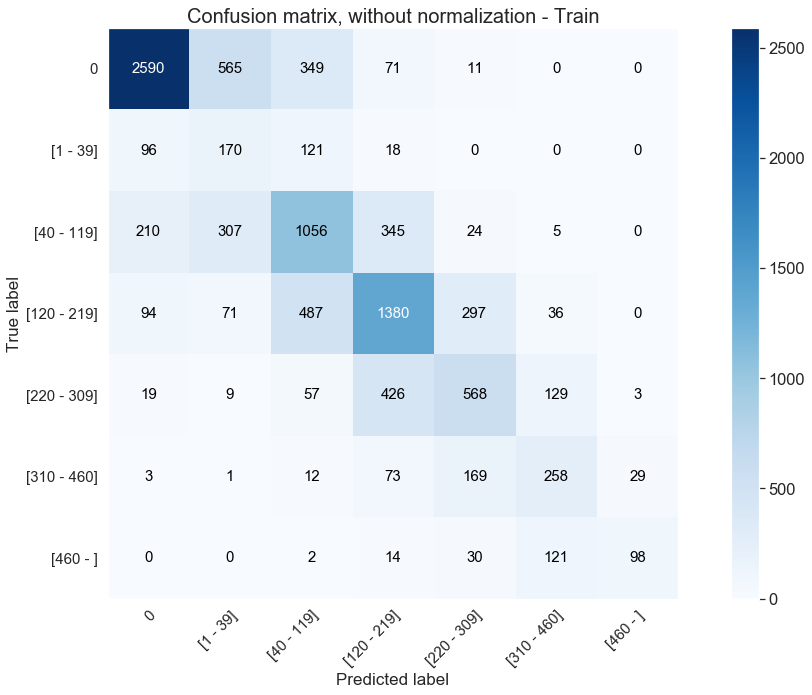

In [96]:
plot_confusion_matrix(epo_binning(cur_epo_train), epo_binning(pred_train), classes=tick_lab,
                      title='Confusion matrix, without normalization - Train')
plt.savefig('Category_Recomm_train.png', dpi=1000)
plt.show()

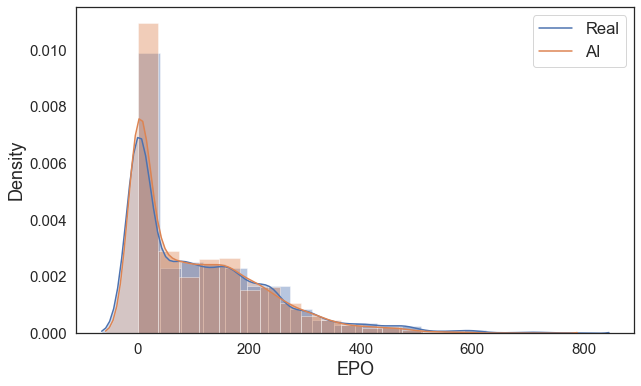

In [152]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_train, bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_train,  bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist - Train.png', dpi=1000)
plt.show()

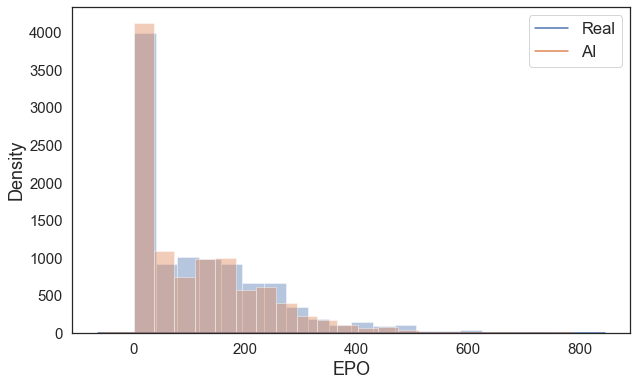

In [151]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_train, bins = num_bins, hist_kws={'density':False}, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_train,  bins = num_bins, hist_kws={'density':False}, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist(Freq) - Train.png', dpi=1000)
plt.show()

### Valid

Confusion matrix, without normalization
[[287  55  27   6   0   1   0]
 [  8  17  15   2   0   0   0]
 [ 31  33 131  56   3   1   0]
 [ 11   3  66 150  32   6   0]
 [  2   2   6  47  43  21   1]
 [  0   1   1   7  28  38   7]
 [  0   0   0   2   3  22  16]]
0.5740740740740741


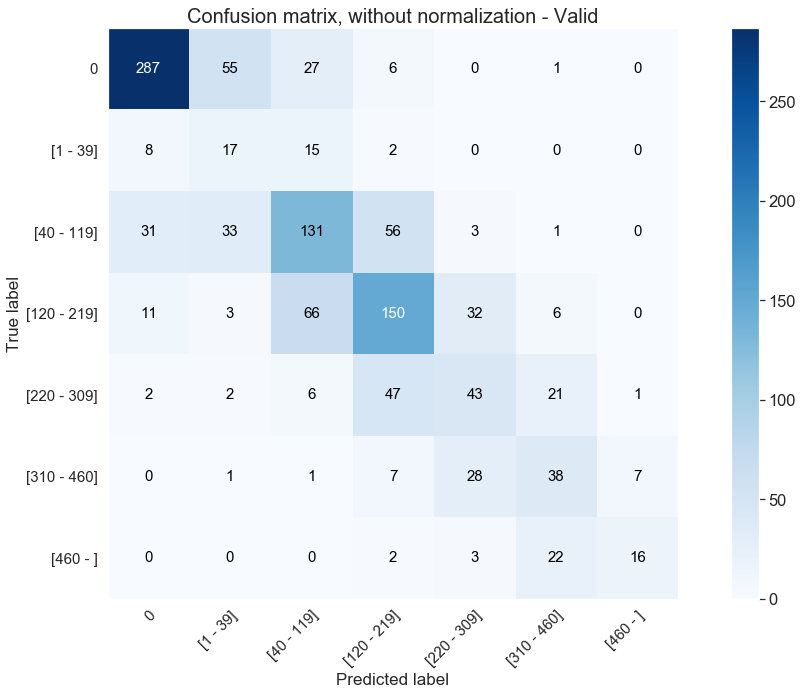

In [97]:
plot_confusion_matrix(epo_binning(cur_epo_valid), epo_binning(pred_valid), classes=tick_lab,
                      title='Confusion matrix, without normalization - Valid')
plt.savefig('Category_Recomm_valid.png', dpi=1000)
plt.show()

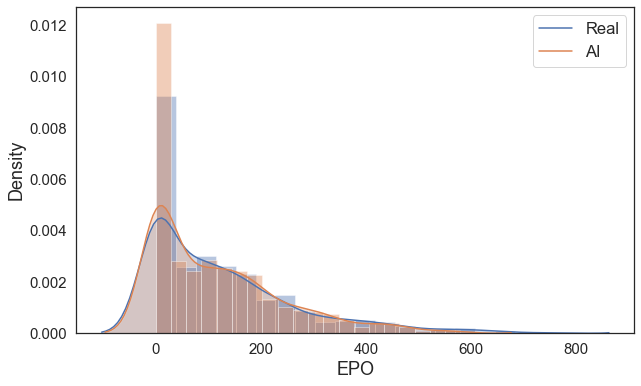

In [150]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_valid, bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_valid,  bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist - Valid.png', dpi=1000)
plt.show()

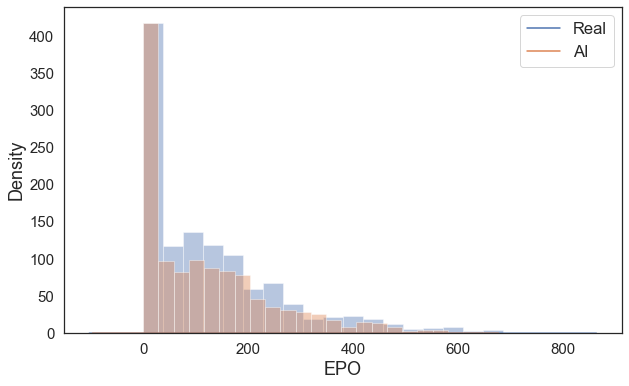

In [149]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_valid, bins = num_bins, hist_kws={'density':False}, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_valid,  bins = num_bins, hist_kws={'density':False}, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist(Freq) - Valid.png', dpi=1000)
plt.show()

### Test

Confusion matrix, without normalization
[[300  55  42  10   4   0   0]
 [ 14  28  24   0   0   0   0]
 [ 39  33 160  45   4   0   0]
 [ 14   9  70 200  42   5   1]
 [  2   3   7  64  62  28   0]
 [  0   0   2   7  24  40   7]
 [  0   0   1   1   6  19  23]]
0.5827956989247312


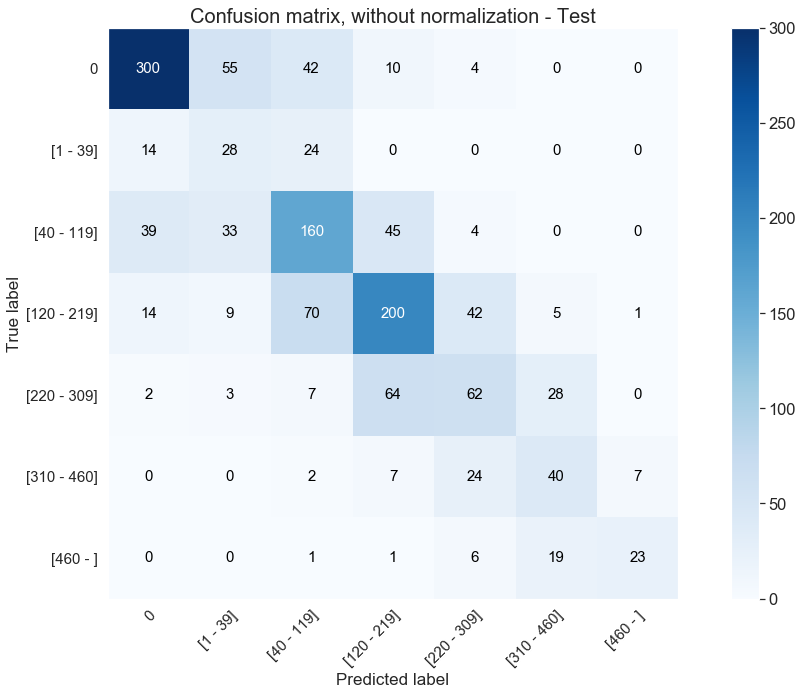

In [98]:
plot_confusion_matrix(epo_binning(cur_epo_test), epo_binning(pred_test), classes=tick_lab,
                      title='Confusion matrix, without normalization - Test')
plt.savefig('Category_Recomm_test.png', dpi=1000)
plt.show()

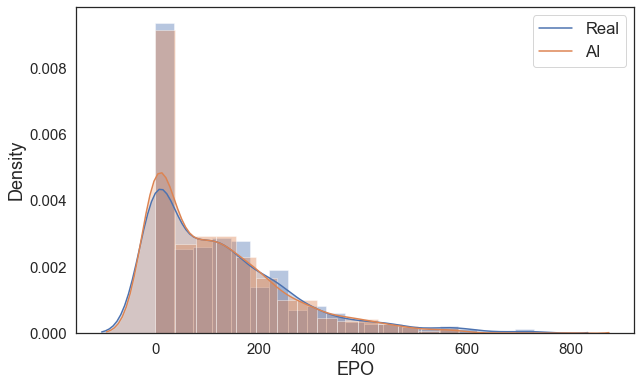

In [99]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_test, bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_test,  bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist - Test.png', dpi=1000)
plt.show()

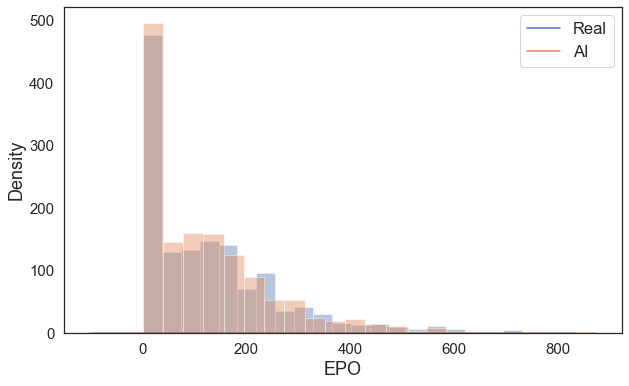

In [147]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_test, bins = num_bins, hist_kws={'density':False}, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_test,  bins = num_bins, hist_kws={'density':False}, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist(Freq) - Test.png', dpi=1000)
plt.show()

## All

Confusion matrix, without normalization
[[3177  675  418   87   15    1    0]
 [ 118  215  160   20    0    0    0]
 [ 280  373 1347  446   31    6    0]
 [ 119   83  623 1730  371   47    1]
 [  23   14   70  537  673  178    4]
 [   3    2   15   87  221  336   43]
 [   0    0    3   17   39  162  137]]
0.5899899279460757


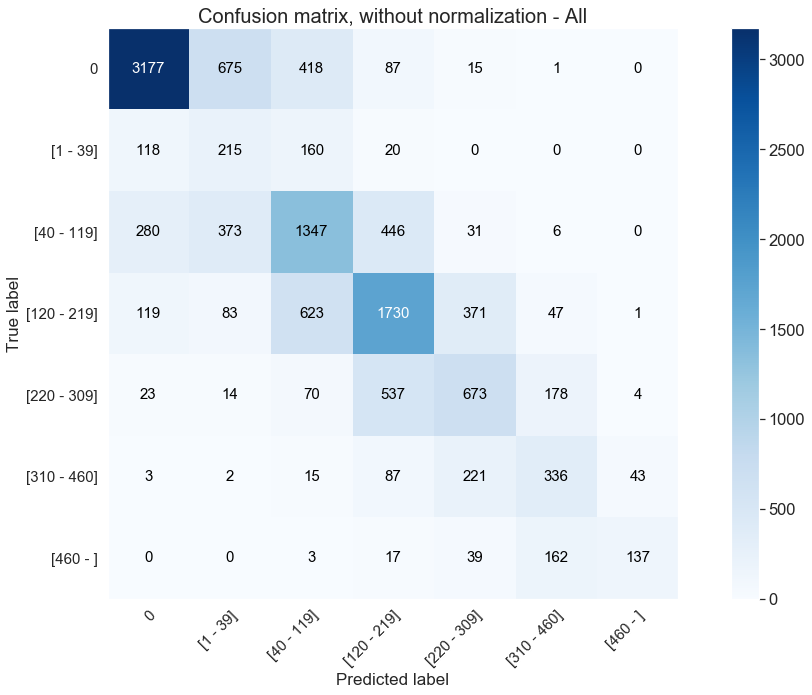

In [100]:
sns.set_style('dark')
plot_confusion_matrix(epo_binning(cur_epo_train.tolist()+cur_epo_valid.tolist()+cur_epo_test.tolist()), 
                      epo_binning(pred_train.tolist()+pred_valid.tolist()+pred_test.tolist()), 
                      classes=tick_lab,
                      title='Confusion matrix, without normalization - All')
plt.savefig('Category_Recomm_All.png', dpi=1000)
plt.show()

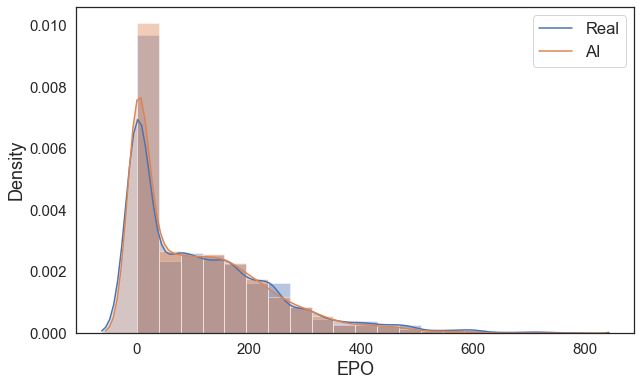

In [145]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_train.tolist()+cur_epo_valid.tolist()+cur_epo_test.tolist(), bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_train.tolist()+pred_valid.tolist()+pred_test.tolist(),  bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist - All.png', dpi=1000)
plt.show()

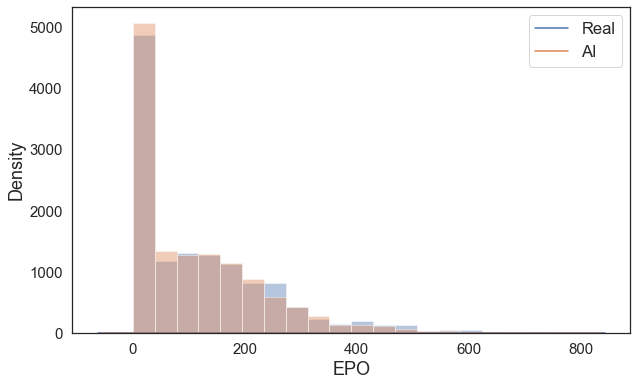

In [146]:
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("white")
num_bins = 20
sns.distplot(cur_epo_train.tolist()+cur_epo_valid.tolist()+cur_epo_test.tolist(), hist_kws={'density':False}, bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "Real"})
sns.distplot(pred_train.tolist()+pred_valid.tolist()+pred_test.tolist(), hist_kws={'density':False}, bins = num_bins, kde=True, kde_kws = {'shade': True, "label": "AI"})
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('EPO')
plt.ylabel('Density')
plt.savefig('ESA Dose Dist(Freq) - All.png', dpi=1000)
plt.show()

# Mean ESA Dose & Hb Variablility

In [132]:
def targeting_hb(x, lower=10.0, upper=12.0):
    if x >= lower and x <= upper:
#         return x
        return 11.0
    elif x < lower:
        return x+1
    elif x > upper:
        return x-1
    
model = get_model()
model.load_weights('./model/gru_mean_{}.h5'.format(seq_len))

def equal_sample_size(a, b):
    if len(a)==len(b):
        return a, b
    elif len(a) > len(b):
        shortage = len(a) - len(b)
        return a, np.array(b.tolist()+[np.nan]*shortage)
    elif len(a) < len(b):
        shortage = len(b) - len(a)
        return np.array(a.tolist()+[np.nan]*shortage), b

### Train

In [54]:
Hb_variability_real_train = []
Hb_variability_ai_train = []
Hb_variability_interval_train = []
esa_amount_real_train = []
esa_amount_ai_train = []

success_real_below10_train = []
fail_real_below10_train = []
success_ai_below10_train = []
fail_ai_below10_train = []

overcor_real_btw1012_train = []
success_real_btw1012_train = []
fail_real_btw1012_train = []
overcor_ai_btw1012_train = []
success_ai_btw1012_train = []
fail_ai_btw1012_train = []

for p in tqdm(train_patient):
    
    x = temp[temp['Study_Subject_Number']==p]
    y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values
    if len(x)>seq_len:
        x = trn_scaler_mean.transform(x[trn_vars])
        for i in range(seq_len, len(x)+1):
            
            x_ = x[i-seq_len:i] # normalized
            
            prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
            prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
            prev_epo = np.abs(prev_epo)

            cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
            cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
            cur_epo = np.abs(cur_epo)
            next_hb = y[i-1] # 10

            target_y = np.array([targeting_hb(cur_hb)]) # 10
            target_y_normalized = transform_target_hb(target_y) # normalized

            past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
            epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9

            epo_pred = ans_process(epo_pred)[0] # 400
            epo_pred_normalized = transform_epo(epo_pred)
            
            x_temp = x_.copy()
            x_temp[-1,epo_idx] = epo_pred_normalized
            
            hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp]))).round(1)
                             
            esa_amount_real_train.append(cur_epo)
            esa_amount_ai_train.append(epo_pred)                
            Hb_variability_real_train.append(next_hb - cur_hb)
            Hb_variability_ai_train.append(hb_AI[0][0] - cur_hb)
            if cur_hb < 10 and next_hb >= 10:
                success_real_below10_train.append(cur_epo)
            elif cur_hb < 10 and next_hb < 10:
                fail_real_below10_train.append(cur_epo)
            if cur_hb < 10 and hb_AI[0][0] >= 10:
                success_ai_below10_train.append(epo_pred)
            elif cur_hb < 10 and hb_AI[0][0] < 10:
                fail_ai_below10_train.append(epo_pred)
                
            if cur_hb >= 10 and cur_hb <= 12 and next_hb > 12:
                overcor_real_btw1012_train.append(cur_epo)
            elif cur_hb >= 10 and cur_hb <= 12 and next_hb <= 12 and next_hb >= 10:
                success_real_btw1012_train.append(cur_epo)  
            elif cur_hb >= 10 and cur_hb <= 12 and next_hb < 10:
                fail_real_btw1012_train.append(cur_epo)                  
            if cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] > 12:
                overcor_ai_btw1012_train.append(epo_pred)
            elif cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] <= 12 and hb_AI[0][0] >= 10:
                success_ai_btw1012_train.append(epo_pred)  
            elif cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] < 10:
                fail_ai_btw1012_train.append(epo_pred)
                
            if cur_hb < 10: 
                Hb_variability_interval_train.append('Below 10')
            elif cur_hb >= 10 and cur_hb <= 12:
                Hb_variability_interval_train.append('Between 10-12')
            elif cur_hb > 12:
                Hb_variability_interval_train.append('Above 12')

100%|████████████████████████████████| 372/372 [01:49<00:00,  3.79it/s]


In [109]:
print('Hb Variability(mean) - Doctors:', np.mean(np.abs(Hb_variability_real_train)).round(2)) 
print('Hb Variability(mean) - AI:', np.mean(np.abs(Hb_variability_ai_train)).round(2))
print('Hb Variability(std) - Doctors:', np.std(np.abs(Hb_variability_real_train)).round(2)) 
print('Hb Variability(std) - AI:', np.std(np.abs(Hb_variability_ai_train)).round(2))
print('Hb Variability(IQR) - Real:', np.percentile(np.abs(Hb_variability_real_train), q=[25,50,75]).round(2))
print('Hb Variability(IQR) - AI:', np.percentile(np.abs(Hb_variability_ai_train), q=[25,50,75]).round(2))
print('-----------------') 
print('-----------------')
non_zero_esa_amount_real_train = np.array([i for i in esa_amount_real_train if i!=0])
non_zero_esa_amount_ai_train = np.array([i for i in esa_amount_ai_train if i!=0])
print('All Data - Doctors:', len(Hb_variability_ai_train))
print('All Data - AI:', len(Hb_variability_ai_train))
print('EPO Valid Data - Doctors:', len(non_zero_esa_amount_real_train))
print('EPO Valid Data - AI:', len(non_zero_esa_amount_ai_train))
print('-----------------')
print('IQR - Real:', np.percentile(non_zero_esa_amount_real_train, q=[25,50,75]))
print('Mean - Real:', np.mean(non_zero_esa_amount_real_train).round(2))
print('Std - Real:', np.std(non_zero_esa_amount_real_train).round(2))
print('Instances - Real:', len(non_zero_esa_amount_real_train))
print('Total ESA Used - Real:', sum(non_zero_esa_amount_real_train))
print('-----------------')
print('IQR - AI:', np.percentile(non_zero_esa_amount_ai_train, q=[25, 50, 75]))
print('Mean - AI:', np.mean(non_zero_esa_amount_ai_train).round(2))
print('Std - AI:', np.std(non_zero_esa_amount_ai_train).round(2))
print('Instances - AI:', len(non_zero_esa_amount_ai_train))
print('Total ESA Used - AI:', sum(non_zero_esa_amount_ai_train))
print('-----------------')
print('-----------------')
print('Below 10')
print('Instances - Doctors:', len(success_real_below10_train)+len(fail_real_below10_train))
print('Instances - AI:', len(success_ai_below10_train)+len(fail_ai_below10_train))
non_zero_success_real_below10_train = np.array([i for i in success_real_below10_train if i!=0])
non_zero_fail_real_below10_train = np.array([i for i in fail_real_below10_train if i!=0])
non_zero_success_ai_below10_train = np.array([i for i in success_ai_below10_train if i!=0])
non_zero_fail_ai_below10_train = np.array([i for i in fail_ai_below10_train if i!=0])
print('Success Rate - Doctors:', len(success_real_below10_train), '|', np.round(len(success_real_below10_train)/(len(success_real_below10_train)+len(fail_real_below10_train))*100,1),'% |', len(success_real_below10_train))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_below10_train).round(2), '/', np.std(non_zero_success_real_below10_train).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_below10_train, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_below10_train), '|', np.round(len(success_ai_below10_train)/(len(success_ai_below10_train)+len(fail_ai_below10_train))*100,1),'% |', len(success_ai_below10_train))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_below10_train).round(2), '/', np.std(non_zero_success_ai_below10_train).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_below10_train, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_below10_train, non_zero_success_ai_below10_train).pvalue)
print('Failure Rate - Doctors:', len(fail_real_below10_train), '|', np.round(len(fail_real_below10_train)/(len(success_real_below10_train)+len(fail_real_below10_train))*100,1),'% |', len(fail_real_below10_train))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_below10_train).round(2), '/', np.std(non_zero_fail_real_below10_train).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_below10_train, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_below10_train), '|', np.round(len(fail_ai_below10_train)/(len(success_ai_below10_train)+len(fail_ai_below10_train))*100,1),'% |', len(fail_ai_below10_train))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_below10_train).round(2), '/', np.std(non_zero_fail_ai_below10_train).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_below10_train, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_below10_train, non_zero_fail_ai_below10_train).pvalue)
print('-----------------')
print('Between 10 - 12')
print('Instances - Doctors:', len(overcor_real_btw1012_train)+len(success_real_btw1012_train)+len(fail_real_btw1012_train))
print('Instances - AI:', len(overcor_ai_btw1012_train)+len(success_ai_btw1012_train)+len(fail_ai_btw1012_train))
non_zero_overcor_real_btw1012_train = np.array([i for i in overcor_real_btw1012_train if i!=0])
non_zero_success_real_btw1012_train = np.array([i for i in success_real_btw1012_train if i!=0])
non_zero_fail_real_btw1012_train = np.array([i for i in fail_real_btw1012_train if i!=0])
non_zero_overcor_ai_btw1012_train = np.array([i for i in overcor_ai_btw1012_train if i!=0])
non_zero_success_ai_btw1012_train = np.array([i for i in success_ai_btw1012_train if i!=0])
non_zero_fail_ai_btw1012_train = np.array([i for i in fail_ai_btw1012_train if i!=0])
print('Overcor Rate - Doctors:', len(overcor_real_btw1012_train), '|', np.round(len(overcor_real_btw1012_train)/(len(overcor_real_btw1012_train)+len(success_real_btw1012_train)+len(fail_real_btw1012_train))*100,1),'% |', len(overcor_real_btw1012_train))
print('Overcor Rate (Mean/Std) - Doctors:', np.mean(non_zero_overcor_real_btw1012_train).round(2), '/', np.std(non_zero_overcor_real_btw1012_train).round(2))
print('Overcor Rate (IQR) - Doctors:', np.percentile(non_zero_overcor_real_btw1012_train, q=[25, 50, 75]))
print('Overcor Rate - AI:', len(overcor_ai_btw1012_train), '|', np.round(len(overcor_ai_btw1012_train)/(len(overcor_ai_btw1012_train)+len(success_ai_btw1012_train)+len(fail_ai_btw1012_train))*100,1),'% |', len(overcor_ai_btw1012_train))
print('Overcor Rate (Mean/Std) - AI:', np.mean(non_zero_overcor_ai_btw1012_train).round(2), '/', np.std(non_zero_overcor_ai_btw1012_train).round(2))
print('Overcor Rate (IQR) - AI:', np.percentile(non_zero_overcor_ai_btw1012_train, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_overcor_real_btw1012_train, non_zero_overcor_ai_btw1012_train).pvalue)
print('Success Rate - Doctors:', len(success_real_btw1012_train), '|', np.round(len(success_real_btw1012_train)/(len(overcor_real_btw1012_train)+len(success_real_btw1012_train)+len(fail_real_btw1012_train))*100,1),'% |', len(success_real_btw1012_train))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_btw1012_train).round(2), '/', np.std(non_zero_success_real_btw1012_train).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_btw1012_train, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_btw1012_train), '|', np.round(len(success_ai_btw1012_train)/(len(overcor_ai_btw1012_train)+len(success_ai_btw1012_train)+len(fail_ai_btw1012_train))*100,1),'% |', len(success_ai_btw1012_train))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_btw1012_train).round(2), '/', np.std(non_zero_success_ai_btw1012_train).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_btw1012_train, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_btw1012_train, non_zero_success_ai_btw1012_train).pvalue)
print('Failure Rate - Doctors:', len(fail_real_btw1012_train), '|', np.round(len(fail_real_btw1012_train)/(len(overcor_real_btw1012_train)+len(success_real_btw1012_train)+len(fail_real_btw1012_train))*100,1),'% |', len(fail_real_btw1012_train))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_btw1012_train).round(2), '/', np.std(non_zero_fail_real_btw1012_train).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_btw1012_train, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_btw1012_train), '|', np.round(len(fail_ai_btw1012_train)/(len(overcor_ai_btw1012_train)+len(success_ai_btw1012_train)+len(fail_ai_btw1012_train))*100,1),'% |', len(fail_ai_btw1012_train))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_btw1012_train).round(2), '/', np.std(non_zero_fail_ai_btw1012_train).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_btw1012_train, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_btw1012_train, non_zero_fail_ai_btw1012_train).pvalue)
print('-----------------')

Hb Variability(mean) - Doctors: 0.95
Hb Variability(mean) - AI: 0.68
Hb Variability(std) - Doctors: 0.74
Hb Variability(std) - AI: 0.53
Hb Variability(IQR) - Real: [0.4 0.8 1.4]
Hb Variability(IQR) - AI: [0.3 0.6 1. ]
-----------------
-----------------
All Data - Doctors: 10314
All Data - AI: 10314
EPO Valid Data - Doctors: 6731
EPO Valid Data - AI: 7552
-----------------
IQR - Real: [ 80. 160. 240.]
Mean - Real: 175.28
Std - Real: 123.2
Instances - Real: 6731
Total ESA Used - Real: 1179821.0
-----------------
IQR - AI: [ 70. 140. 210.]
Mean - AI: 150.71
Std - AI: 102.72
Instances - AI: 7552
Total ESA Used - AI: 1138160
-----------------
-----------------
Below 10
Instances - Doctors: 2181
Instances - AI: 2181
Success Rate - Doctors: 1414 | 64.8 % | 1414
Success Rate (Mean/Std) - Doctors: 259.52 / 128.95
Success Rate (IQR) - Doctors: [170. 240. 320.]
Success Rate - AI: 1690 | 77.5 % | 1690
Success Rate (Mean/Std) - AI: 229.57 / 97.88
Success Rate (IQR) - AI: [170. 220. 280.]
T-test p-

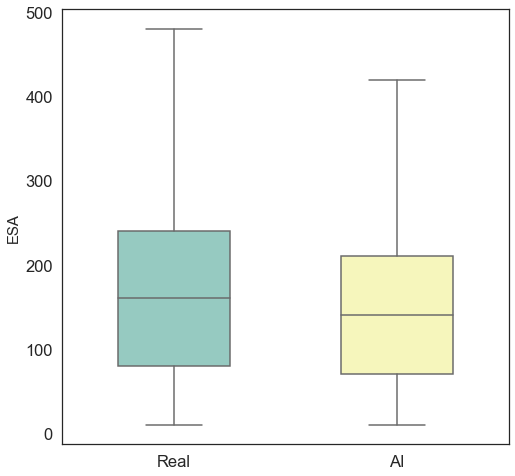

ESA T-test p-value: 2.279386904596829e-38


In [110]:
a, b = equal_sample_size(non_zero_esa_amount_real_train, non_zero_esa_amount_ai_train)
non_esa_amount_train = pd.DataFrame({'Real': a, 'AI': b})
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=non_esa_amount_train, width=0.5, palette="Set3", showfliers=False)
plt.savefig('ESA_Dose_BoxPlot - Train',dpi=1000)
plt.ylabel('ESA', fontsize=15)
plt.show()
print('ESA T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_train, non_zero_esa_amount_ai_train).pvalue)

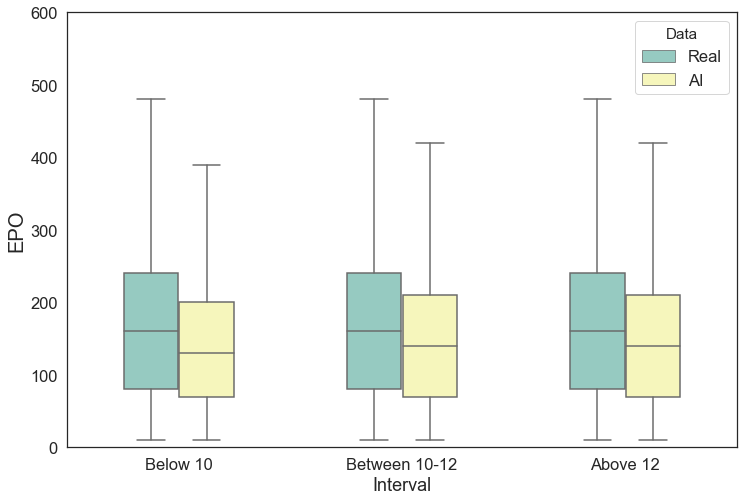

All
All Instances: 10314
ESA - Real: 175.28168177091072 123.20030779925304
ESA - AI: 150.70974576271186 102.71551067795782
T-test p-value: 2.279386904596829e-38
--------------------
Below 10
All Instances: 2181
Instances (EPO > 0) - Real: 1321
ESA (Mean/Std) - Real: 180.3 / 125.8
ESA (IQR)- Real: [ 80. 160. 240.]
Instances (EPO > 0) - AI: 1518
ESA (Mean/Std) - AI: 146.6 / 101.1
ESA (IQR)- AI: [ 70. 130. 200.]
T-test p-value (Real vs AI): 3.645877244031417e-15
--------------------
Between 10-12
All Instances: 6860
Instances (EPO > 0) - Real: 4582
ESA (Mean/Std) - Real: 155.4 / 110.5
ESA (IQR)- Real: [ 80. 130. 200.]
Instances (EPO > 0) - AI: 5056
ESA (Mean/Std) - AI: 129.8 / 96.9
ESA (IQR)- AI: [ 50. 110. 180.]
T-test p-value (Real vs AI): 1.7555857195275095e-33
--------------------
Above 12
All Instances: 1273
Instances (EPO > 0) - Real: 392
ESA (Mean/Std) - Real: 67.9 / 47.3
ESA (IQR)- Real: [40. 60. 80.]
Instances (EPO > 0) - AI: 448
ESA (Mean/Std) - AI: 40.8 / 34.2
ESA (IQR)- AI: [1

In [154]:
fixed_length_non_zero_esa_amount_real_train = [np.nan]*(len(Hb_variability_interval_train) - len(non_zero_esa_amount_real_train)) + non_zero_esa_amount_real_train.tolist() 
fixed_length_non_zero_esa_amount_ai_train = [np.nan]*(len(Hb_variability_interval_train) - len(non_zero_esa_amount_ai_train)) + non_zero_esa_amount_ai_train.tolist()
recommended_epo_by_interval_train = pd.DataFrame({'Interval': Hb_variability_interval_train + Hb_variability_interval_train, 
                                                'EPO': fixed_length_non_zero_esa_amount_real_train + fixed_length_non_zero_esa_amount_ai_train,
                                                 'Data': ['Real']*len(Hb_variability_interval_train) + ['AI']*len(Hb_variability_interval_train)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="EPO", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=recommended_epo_by_interval_train, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('EPO', fontsize=20)
plt.ylim(0, 600)
plt.savefig('Recommended_ESA_Dose_BoxPlot - Train',dpi=1000)
plt.show()
print('All')
print('All Instances:', len(Hb_variability_interval_train))
print('ESA - Real:', np.mean(non_zero_esa_amount_real_train), np.std(non_zero_esa_amount_real_train))
print('ESA - AI:', np.mean(non_zero_esa_amount_ai_train), np.std(non_zero_esa_amount_ai_train))
print('T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_train, non_zero_esa_amount_ai_train).pvalue)
print('--------------------')
print('Below 10')
print('All Instances:', len([i for i in Hb_variability_interval_train if i =='Below 10']))
recommended_non_zero_real_epo_non_na_below10_train = [e for i, e in zip(Hb_variability_interval_train, fixed_length_non_zero_esa_amount_real_train) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_below10_train))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_below10_train).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_below10_train).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_below10_train, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_below10_train = [e for i, e in zip(Hb_variability_interval_train, fixed_length_non_zero_esa_amount_ai_train) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_below10_train))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_below10_train).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_below10_train).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_below10_train, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_below10_train, recommended_non_zero_ai_epo_non_na_below10_train).pvalue)
print('--------------------')
print('Between 10-12')
print('All Instances:', len([i for i in Hb_variability_interval_train if i =='Between 10-12']))
recommended_non_zero_real_epo_non_na_btw1012_train = [e for i, e in zip(Hb_variability_interval_train, non_zero_real_epo_train) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_btw1012_train))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_btw1012_train).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_btw1012_train).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_btw1012_train, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_btw1012_train = [e for i, e in zip(Hb_variability_interval_train, non_zero_ai_epo_train) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_btw1012_train))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_btw1012_train).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_btw1012_train).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_btw1012_train, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_btw1012_train, recommended_non_zero_ai_epo_non_na_btw1012_train).pvalue)
print('--------------------')
print('Above 12')
print('All Instances:', len([i for i in Hb_variability_interval_train if i =='Above 12']))
recommended_non_zero_real_epo_non_na_above12_train = [e for i, e in zip(Hb_variability_interval_train, non_zero_real_epo_train) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_above12_train))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_above12_train).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_above12_train).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_above12_train, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_above12_train = [e for i, e in zip(Hb_variability_interval_train, non_zero_ai_epo_train) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_above12_train))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_above12_train).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_train).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_above12_train, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_above12_train, recommended_non_zero_ai_epo_non_na_above12_train).pvalue)

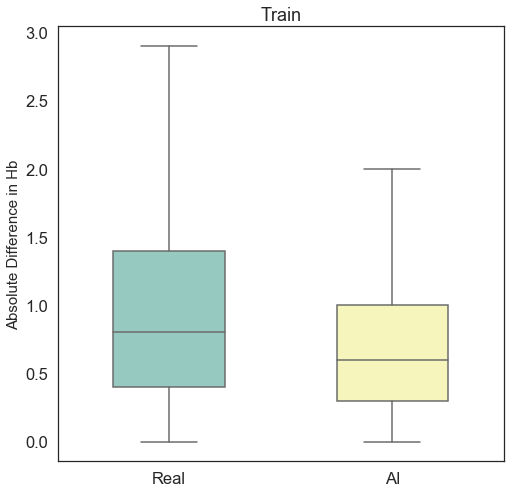

T-test p-value: 3.430712915748304e-185


In [113]:
Hb_variability_train = pd.DataFrame({'Real': np.abs(Hb_variability_real_train), 'AI': np.abs(Hb_variability_ai_train)})
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=Hb_variability_train, width=0.5, palette="Set3", showfliers=False)
plt.title('Train')
plt.ylabel('Absolute Difference in Hb', fontsize=15)
plt.savefig('Hb_Variability_BoxPlot - Train',dpi=1000)
plt.show()
print('T-test p-value:', stats.ttest_ind(np.abs(Hb_variability_real_train), np.abs(Hb_variability_ai_train)).pvalue)

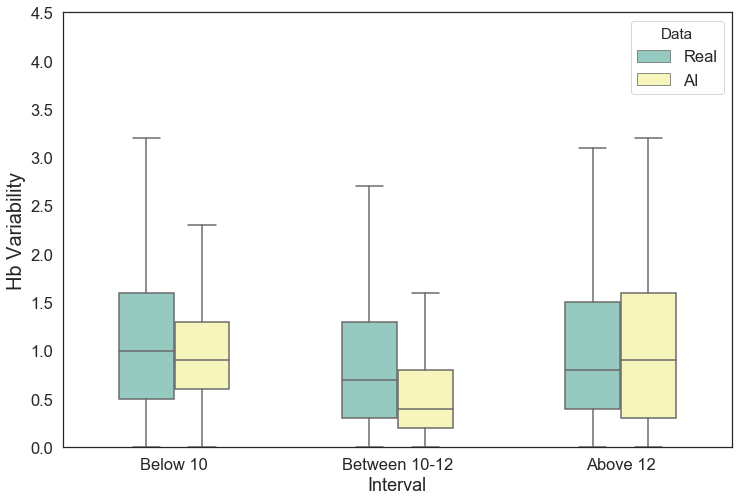

Counter({'Between 10-12': 6860, 'Below 10': 2181, 'Above 12': 1273})
10314


In [114]:
Hb_variability_by_interval_train = pd.DataFrame({'Interval': Hb_variability_interval_train+Hb_variability_interval_train, 
                                                 'Hb_variability': np.abs(Hb_variability_real_train+Hb_variability_ai_train), 
                                                 'Data': ['Real']*len(Hb_variability_real_train) + ['AI']*len(Hb_variability_ai_train)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="Hb_variability", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=Hb_variability_by_interval_train, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('Hb Variability', fontsize=20)
plt.ylim(0, 4.5)
plt.savefig('Hb_Variability_BoxPlot_Interval - Train',dpi=1000)
plt.show()
print(Counter(Hb_variability_interval_train))
print(len(Hb_variability_interval_train))

### Valid

In [55]:
Hb_variability_real_valid = []
Hb_variability_ai_valid = []
Hb_variability_interval_valid = []
esa_amount_real_valid = []
esa_amount_ai_valid = []

success_real_below10_valid = []
fail_real_below10_valid = []
success_ai_below10_valid = []
fail_ai_below10_valid = []

overcor_real_btw1012_valid = []
success_real_btw1012_valid = []
fail_real_btw1012_valid = []
overcor_ai_btw1012_valid = []
success_ai_btw1012_valid = []
fail_ai_btw1012_valid = []

for p in tqdm(valid_patient):
    
    x = temp[temp['Study_Subject_Number']==p]
    y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values
    if len(x)>seq_len:
        x = trn_scaler_mean.transform(x[trn_vars])
        for i in range(seq_len, len(x)+1):
            
            x_ = x[i-seq_len:i] # normalized
            
            prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
            prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
            prev_epo = np.abs(prev_epo)

            cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
            cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
            cur_epo = np.abs(cur_epo)
            next_hb = y[i-1] # 10

            target_y = np.array([targeting_hb(cur_hb)]) # 10
            target_y_normalized = transform_target_hb(target_y) # normalized

            past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
            epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9

            epo_pred = ans_process(epo_pred)[0] # 400
            epo_pred_normalized = transform_epo(epo_pred)
            
            x_temp = x_.copy()
            x_temp[-1,epo_idx] = epo_pred_normalized
            
            hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp]))).round(1)
                             
            esa_amount_real_valid.append(cur_epo)
            esa_amount_ai_valid.append(epo_pred)                
            Hb_variability_real_valid.append(next_hb - cur_hb)
            Hb_variability_ai_valid.append(hb_AI[0][0] - cur_hb)
            if cur_hb < 10 and next_hb >= 10:
                success_real_below10_valid.append(cur_epo)
            elif cur_hb < 10 and next_hb < 10:
                fail_real_below10_valid.append(cur_epo)            
            if cur_hb < 10 and hb_AI[0][0] >= 10:
                success_ai_below10_valid.append(epo_pred)
            elif cur_hb < 10 and hb_AI[0][0] < 10:
                fail_ai_below10_valid.append(epo_pred)
                
            if cur_hb >= 10 and cur_hb <= 12 and next_hb > 12:
                overcor_real_btw1012_valid.append(cur_epo)
            elif cur_hb >= 10 and cur_hb <= 12 and next_hb <= 12 and next_hb >= 10:
                success_real_btw1012_valid.append(cur_epo)  
            elif cur_hb >= 10 and cur_hb <= 12 and next_hb < 10:
                fail_real_btw1012_valid.append(cur_epo)                  
            if cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] > 12:
                overcor_ai_btw1012_valid.append(epo_pred)
            elif cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] <= 12 and hb_AI[0][0] >= 10:
                success_ai_btw1012_valid.append(epo_pred)  
            elif cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] < 10:
                fail_ai_btw1012_valid.append(epo_pred)
                
            if cur_hb < 10: 
                Hb_variability_interval_valid.append('Below 10')
            elif cur_hb >= 10 and cur_hb <= 12:
                Hb_variability_interval_valid.append('Between 10-12')
            elif cur_hb > 12:
                Hb_variability_interval_valid.append('Above 12')

100%|██████████████████████████████████| 47/47 [00:12<00:00,  3.70it/s]


In [138]:
print('Hb Variability(mean) - Doctors:', np.mean(np.abs(Hb_variability_real_valid)).round(2)) 
print('Hb Variability(mean) - AI:', np.mean(np.abs(Hb_variability_ai_valid)).round(2))
print('Hb Variability(std) - Doctors:', np.std(np.abs(Hb_variability_real_valid)).round(2)) 
print('Hb Variability(std) - AI:', np.std(np.abs(Hb_variability_ai_valid)).round(2))
print('Hb Variability(IQR) - Real:', np.percentile(np.abs(Hb_variability_real_valid), q=[25,50,75]).round(2))
print('Hb Variability(IQR) - AI:', np.percentile(np.abs(Hb_variability_ai_valid), q=[25,50,75]).round(2))
print('-----------------') 
print('-----------------')
non_zero_esa_amount_real_valid = np.array([i for i in esa_amount_real_valid if i!=0])
non_zero_esa_amount_ai_valid = np.array([i for i in esa_amount_ai_valid if i!=0])
print('All Data - Doctors:', len(Hb_variability_ai_valid))
print('All Data - AI:', len(Hb_variability_ai_valid))
print('EPO Valid Data - Doctors:', len(non_zero_esa_amount_real_valid))
print('EPO Valid Data - AI:', len(non_zero_esa_amount_ai_valid))
print('-----------------')
print('IQR - Real:', np.percentile(non_zero_esa_amount_real_valid, q=[25,50,75]))
print('Mean - Real:', np.mean(non_zero_esa_amount_real_valid).round(2))
print('Std - Real:', np.std(non_zero_esa_amount_real_valid).round(2))
print('Instances - Real:', len(non_zero_esa_amount_real_valid))
print('Total ESA Used - Real:', sum(non_zero_esa_amount_real_valid))
print('-----------------')
print('IQR - AI:', np.percentile(non_zero_esa_amount_ai_valid, q=[25, 50, 75]))
print('Mean - AI:', np.mean(non_zero_esa_amount_ai_valid).round(2))
print('Std - AI:', np.std(non_zero_esa_amount_ai_valid).round(2))
print('Instances - AI:', len(non_zero_esa_amount_ai_valid))
print('Total ESA Used - AI:', sum(non_zero_esa_amount_ai_valid))
print('-----------------')
print('-----------------')
print('Below 10')
print('Instances - Doctors:', len(success_real_below10_valid)+len(fail_real_below10_valid))
print('Instances - AI:', len(success_ai_below10_valid)+len(fail_ai_below10_valid))
non_zero_success_real_below10_valid = np.array([i for i in success_real_below10_valid if i!=0])
non_zero_fail_real_below10_valid = np.array([i for i in fail_real_below10_valid if i!=0])
non_zero_success_ai_below10_valid = np.array([i for i in success_ai_below10_valid if i!=0])
non_zero_fail_ai_below10_valid = np.array([i for i in fail_ai_below10_valid if i!=0])
print('Success Rate - Doctors:', len(success_real_below10_valid), '|', np.round(len(success_real_below10_valid)/(len(success_real_below10_valid)+len(fail_real_below10_valid))*100,1),'% |', len(success_real_below10_valid))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_below10_valid).round(2), '/', np.std(non_zero_success_real_below10_valid).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_below10_valid, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_below10_valid), '|', np.round(len(success_ai_below10_valid)/(len(success_ai_below10_valid)+len(fail_ai_below10_valid))*100,1),'% |', len(success_ai_below10_valid))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_below10_valid).round(2), '/', np.std(non_zero_success_ai_below10_valid).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_below10_valid, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_below10_valid, non_zero_success_ai_below10_valid).pvalue)
print('Failure Rate - Doctors:', len(fail_real_below10_valid), '|', np.round(len(fail_real_below10_valid)/(len(success_real_below10_valid)+len(fail_real_below10_valid))*100,1),'% |', len(fail_real_below10_valid))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_below10_valid).round(2), '/', np.std(non_zero_fail_real_below10_valid).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_below10_valid, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_below10_valid), '|', np.round(len(fail_ai_below10_valid)/(len(success_ai_below10_valid)+len(fail_ai_below10_valid))*100,1),'% |', len(fail_ai_below10_valid))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_below10_valid).round(2), '/', np.std(non_zero_fail_ai_below10_valid).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_below10_valid, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_below10_valid, non_zero_fail_ai_below10_valid).pvalue)
print('-----------------')
print('Between 10 - 12')
print('Instances - Doctors:', len(overcor_real_btw1012_valid)+len(success_real_btw1012_valid)+len(fail_real_btw1012_valid))
print('Instances - AI:', len(overcor_ai_btw1012_valid)+len(success_ai_btw1012_valid)+len(fail_ai_btw1012_valid))
non_zero_overcor_real_btw1012_valid = np.array([i for i in overcor_real_btw1012_valid if i!=0])
non_zero_success_real_btw1012_valid = np.array([i for i in success_real_btw1012_valid if i!=0])
non_zero_fail_real_btw1012_valid = np.array([i for i in fail_real_btw1012_valid if i!=0])
non_zero_overcor_ai_btw1012_valid = np.array([i for i in overcor_ai_btw1012_valid if i!=0])
non_zero_success_ai_btw1012_valid = np.array([i for i in success_ai_btw1012_valid if i!=0])
non_zero_fail_ai_btw1012_valid = np.array([i for i in fail_ai_btw1012_valid if i!=0])
print('Overcor Rate - Doctors:', len(overcor_real_btw1012_valid), '|', np.round(len(overcor_real_btw1012_valid)/(len(overcor_real_btw1012_valid)+len(success_real_btw1012_valid)+len(fail_real_btw1012_valid))*100,1),'% |', len(overcor_real_btw1012_valid))
print('Overcor Rate (Mean/Std) - Doctors:', np.mean(non_zero_overcor_real_btw1012_valid).round(2), '/', np.std(non_zero_overcor_real_btw1012_valid).round(2))
print('Overcor Rate (IQR) - Doctors:', np.percentile(non_zero_overcor_real_btw1012_valid, q=[25, 50, 75]))
print('Overcor Rate - AI:', len(overcor_ai_btw1012_valid), '|', np.round(len(overcor_ai_btw1012_valid)/(len(overcor_ai_btw1012_valid)+len(success_ai_btw1012_valid)+len(fail_ai_btw1012_valid))*100,1),'% |', len(overcor_ai_btw1012_valid))
print('Overcor Rate (Mean/Std) - AI:', np.mean(non_zero_overcor_ai_btw1012_valid).round(2), '/', np.std(non_zero_overcor_ai_btw1012_valid).round(2))
print('Overcor Rate (IQR) - AI:', np.percentile(non_zero_overcor_ai_btw1012_valid, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_overcor_real_btw1012_valid, non_zero_overcor_ai_btw1012_valid).pvalue)
print('Success Rate - Doctors:', len(success_real_btw1012_valid), '|', np.round(len(success_real_btw1012_valid)/(len(overcor_real_btw1012_valid)+len(success_real_btw1012_valid)+len(fail_real_btw1012_valid))*100,1),'% |', len(success_real_btw1012_valid))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_btw1012_valid).round(2), '/', np.std(non_zero_success_real_btw1012_valid).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_btw1012_valid, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_btw1012_valid), '|', np.round(len(success_ai_btw1012_valid)/(len(overcor_ai_btw1012_valid)+len(success_ai_btw1012_valid)+len(fail_ai_btw1012_valid))*100,1),'% |', len(success_ai_btw1012_valid))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_btw1012_valid).round(2), '/', np.std(non_zero_success_ai_btw1012_valid).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_btw1012_valid, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_btw1012_valid, non_zero_success_ai_btw1012_valid).pvalue)
print('Failure Rate - Doctors:', len(fail_real_btw1012_valid), '|', np.round(len(fail_real_btw1012_valid)/(len(overcor_real_btw1012_valid)+len(success_real_btw1012_valid)+len(fail_real_btw1012_valid))*100,1),'% |', len(fail_real_btw1012_valid))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_btw1012_valid).round(2), '/', np.std(non_zero_fail_real_btw1012_valid).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_btw1012_valid, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_btw1012_valid), '|', np.round(len(fail_ai_btw1012_valid)/(len(overcor_ai_btw1012_valid)+len(success_ai_btw1012_valid)+len(fail_ai_btw1012_valid))*100,1),'% |', len(fail_ai_btw1012_valid))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_btw1012_valid).round(2), '/', np.std(non_zero_fail_ai_btw1012_valid).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_btw1012_valid, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_btw1012_valid, non_zero_fail_ai_btw1012_valid).pvalue)
print('-----------------')

Hb Variability(mean) - Doctors: 0.92
Hb Variability(mean) - AI: 0.68
Hb Variability(std) - Doctors: 0.76
Hb Variability(std) - AI: 0.52
Hb Variability(IQR) - Real: [0.3 0.7 1.3]
Hb Variability(IQR) - AI: [0.3 0.6 1. ]
-----------------
-----------------
All Data - Doctors: 1188
All Data - AI: 1188
EPO Valid Data - Doctors: 812
EPO Valid Data - AI: 893
-----------------
IQR - Real: [ 80. 150. 240.]
Mean - Real: 182.78
Std - Real: 135.98
Instances - Real: 812
Total ESA Used - Real: 148415.0
-----------------
IQR - AI: [ 70. 140. 220.]
Mean - AI: 161.01
Std - AI: 119.12
Instances - AI: 893
Total ESA Used - AI: 143780
-----------------
-----------------
Below 10
Instances - Doctors: 264
Instances - AI: 264
Success Rate - Doctors: 154 | 58.3 % | 154
Success Rate (Mean/Std) - Doctors: 240.75 / 134.63
Success Rate (IQR) - Doctors: [150. 210. 300.]
Success Rate - AI: 177 | 67.0 % | 177
Success Rate (Mean/Std) - AI: 223.51 / 102.96
Success Rate (IQR) - AI: [155. 200. 280.]
T-test p-value: 0.225

C:\Users\A\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\A\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\A\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\A\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\A\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


T-test p-value: nan
Success Rate - Doctors: 559 | 71.8 % | 559
Success Rate (Mean/Std) - Doctors: 155.35 / 106.79
Success Rate (IQR) - Doctors: [ 80. 120. 200.]
Success Rate - AI: 736 | 94.5 % | 736
Success Rate (Mean/Std) - AI: 139.75 / 91.92
Success Rate (IQR) - AI: [ 70. 120. 190.]
T-test p-value: 0.013511285208678284
Failure Rate - Doctors: 150 | 19.3 % | 150
Failure Rate (Mean/Std) - Doctors: 124.41 / 110.53
Failure Rate (IQR) - Doctors: [ 60.  80. 160.]
Failure Rate - AI: 38 | 4.9 % | 38
Failure Rate (Mean/Std) - AI: 126.43 / 150.55
Failure Rate (IQR) - AI: [ 30.  60. 150.]
T-test p-value: 0.9529574865361299
-----------------


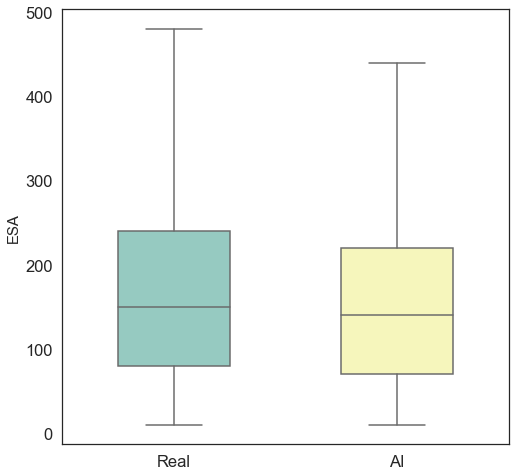

ESA T-test p-value: 0.0004412048697553815


In [139]:
a, b = equal_sample_size(non_zero_esa_amount_real_valid, non_zero_esa_amount_ai_valid)
non_esa_amount_valid = pd.DataFrame({'Real': a, 'AI': b}) 
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=non_esa_amount_valid, width=0.5, palette="Set3", showfliers=False)
plt.savefig('ESA_Dose_BoxPlot - Valid',dpi=1000)
plt.ylabel('ESA', fontsize=15)
plt.show()
print('ESA T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_valid, non_zero_esa_amount_ai_valid).pvalue)

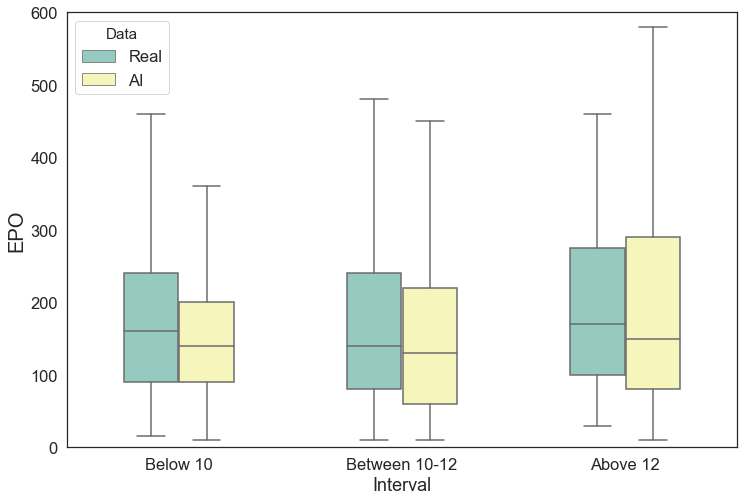

All
All Instances: 1188
ESA - Real: 182.7770935960591 135.9805778562306
ESA - AI: 161.00783874580068 119.11719386219798
T-test p-value: 0.0004412048697553815
--------------------
Below 10
All Instances: 264
Instances (EPO > 0) - Real: 179
ESA (Mean/Std) - Real: 183.7 / 135.1
ESA (IQR)- Real: [ 90. 160. 240.]
Instances (EPO > 0) - AI: 194
ESA (Mean/Std) - AI: 153.5 / 100.2
ESA (IQR)- AI: [ 90. 140. 200.]
T-test p-value (Real vs AI): 0.014310647289022083
--------------------
Between 10-12
All Instances: 779
Instances (EPO > 0) - Real: 551
ESA (Mean/Std) - Real: 160.4 / 117.5
ESA (IQR)- Real: [ 80. 120. 210.]
Instances (EPO > 0) - AI: 574
ESA (Mean/Std) - AI: 140.1 / 99.5
ESA (IQR)- AI: [ 60. 120. 190.]
T-test p-value (Real vs AI): 0.0017704725036291093
--------------------
Above 12
All Instances: 145
Instances (EPO > 0) - Real: 44
ESA (Mean/Std) - Real: 72.5 / 58.2
ESA (IQR)- Real: [40. 60. 80.]
Instances (EPO > 0) - AI: 61
ESA (Mean/Std) - AI: 43.1 / 32.9
ESA (IQR)- AI: [20. 30. 60.]
T-

In [152]:
fixed_length_non_zero_esa_amount_real_valid = [np.nan]*(len(Hb_variability_interval_valid) - len(non_zero_esa_amount_real_valid)) + non_zero_esa_amount_real_valid.tolist() 
fixed_length_non_zero_esa_amount_ai_valid = [np.nan]*(len(Hb_variability_interval_valid) - len(non_zero_esa_amount_ai_valid)) + non_zero_esa_amount_ai_valid.tolist()
recommended_epo_by_interval_valid = pd.DataFrame({'Interval': Hb_variability_interval_valid + Hb_variability_interval_valid, 
                                                'EPO': fixed_length_non_zero_esa_amount_real_valid + fixed_length_non_zero_esa_amount_ai_valid,
                                                 'Data': ['Real']*len(Hb_variability_interval_valid) + ['AI']*len(Hb_variability_interval_valid)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="EPO", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=recommended_epo_by_interval_valid, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('EPO', fontsize=20)
plt.ylim(0, 600)
plt.savefig('Recommended_ESA_Dose_BoxPlot - Valid',dpi=1000)
plt.show()
print('All')
print('All Instances:', len(Hb_variability_interval_valid))
print('ESA - Real:', np.mean(non_zero_esa_amount_real_valid), np.std(non_zero_esa_amount_real_valid))
print('ESA - AI:', np.mean(non_zero_esa_amount_ai_valid), np.std(non_zero_esa_amount_ai_valid))
print('T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_valid, non_zero_esa_amount_ai_valid).pvalue)
print('--------------------')
print('Below 10')
print('All Instances:', len([i for i in Hb_variability_interval_valid if i =='Below 10']))
recommended_non_zero_real_epo_non_na_below10_valid = [e for i, e in zip(Hb_variability_interval_valid, fixed_length_non_zero_esa_amount_real_valid) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_below10_valid))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_below10_valid).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_below10_valid).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_below10_valid, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_below10_valid = [e for i, e in zip(Hb_variability_interval_valid, fixed_length_non_zero_esa_amount_ai_valid) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_below10_valid))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_below10_valid).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_below10_valid).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_below10_valid, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_below10_valid, recommended_non_zero_ai_epo_non_na_below10_valid).pvalue)
print('--------------------')
print('Between 10-12')
print('All Instances:', len([i for i in Hb_variability_interval_valid if i =='Between 10-12']))
recommended_non_zero_real_epo_non_na_btw1012_valid = [e for i, e in zip(Hb_variability_interval_valid, non_zero_real_epo_valid) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_btw1012_valid))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_btw1012_valid).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_btw1012_valid).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_btw1012_valid, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_btw1012_valid = [e for i, e in zip(Hb_variability_interval_valid, non_zero_ai_epo_valid) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_btw1012_valid))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_btw1012_valid).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_btw1012_valid).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_btw1012_valid, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_btw1012_valid, recommended_non_zero_ai_epo_non_na_btw1012_valid).pvalue)
print('--------------------')
print('Above 12')
print('All Instances:', len([i for i in Hb_variability_interval_valid if i =='Above 12']))
recommended_non_zero_real_epo_non_na_above12_valid = [e for i, e in zip(Hb_variability_interval_valid, non_zero_real_epo_valid) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_above12_valid))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_above12_valid).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_above12_valid).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_above12_valid, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_above12_valid = [e for i, e in zip(Hb_variability_interval_valid, non_zero_ai_epo_valid) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_above12_valid))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_above12_valid).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_valid).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_above12_valid, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_above12_valid, recommended_non_zero_ai_epo_non_na_above12_valid).pvalue)

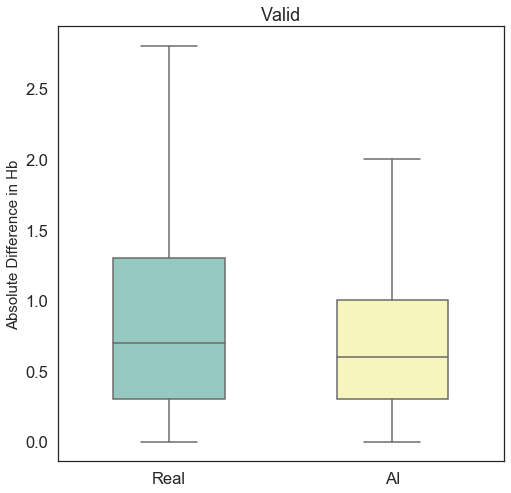

T-test p-value: 8.590674503900513e-19


In [126]:
Hb_variability_valid = pd.DataFrame({'Real': np.abs(Hb_variability_real_valid), 'AI': np.abs(Hb_variability_ai_valid)})
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=Hb_variability_valid, width=0.5, palette="Set3", showfliers=False)
plt.title('Valid')
plt.ylabel('Absolute Difference in Hb', fontsize=15)
plt.savefig('Hb_Variability_BoxPlot - Valid',dpi=1000)
plt.show()
print('T-test p-value:', stats.ttest_ind(np.abs(Hb_variability_real_valid), np.abs(Hb_variability_ai_valid)).pvalue)

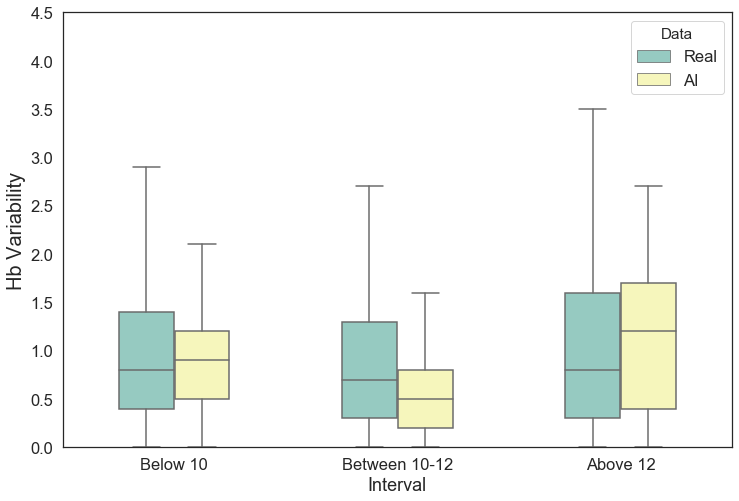

Counter({'Between 10-12': 779, 'Below 10': 264, 'Above 12': 145})
1188


In [114]:
Hb_variability_by_interval_valid = pd.DataFrame({'Interval': Hb_variability_interval_valid+Hb_variability_interval_valid, 
                                                 'Hb_variability': np.abs(Hb_variability_real_valid+Hb_variability_ai_valid), 
                                                 'Data': ['Real']*len(Hb_variability_real_valid) + ['AI']*len(Hb_variability_ai_valid)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="Hb_variability", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=Hb_variability_by_interval_valid, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('Hb Variability', fontsize=20)
plt.ylim(0, 4.5)
plt.savefig('Hb_Variability_BoxPlot_Interval - Valid',dpi=1000)
plt.show()
print(Counter(Hb_variability_interval_valid))
print(len(Hb_variability_interval_valid))

### Test

In [56]:
Hb_variability_real_test = []
Hb_variability_ai_test = []
Hb_variability_interval_test = []
esa_amount_real_test = []
esa_amount_ai_test = []

success_real_below10_test = []
fail_real_below10_test = []
success_ai_below10_test = []
fail_ai_below10_test = []

overcor_real_btw1012_test = []
success_real_btw1012_test = []
fail_real_btw1012_test = []
overcor_ai_btw1012_test = []
success_ai_btw1012_test = []
fail_ai_btw1012_test = []

for p in tqdm(test_patient):
    
    x = temp[temp['Study_Subject_Number']==p]
    y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values
    if len(x)>seq_len:
        x = trn_scaler_mean.transform(x[trn_vars])
        for i in range(seq_len, len(x)+1):
            
            x_ = x[i-seq_len:i] # normalized
            
            prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
            prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
            prev_epo = np.abs(prev_epo)

            cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
            cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
            cur_epo = np.abs(cur_epo)
            next_hb = y[i-1] # 10

            target_y = np.array([targeting_hb(cur_hb)]) # 10
            target_y_normalized = transform_target_hb(target_y) # normalized

            past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
            epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9

            epo_pred = ans_process(epo_pred)[0] # 400
            epo_pred_normalized = transform_epo(epo_pred)
            
            x_temp = x_.copy()
            x_temp[-1,epo_idx] = epo_pred_normalized
            
            hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp]))).round(1)
                             
            esa_amount_real_test.append(cur_epo)
            esa_amount_ai_test.append(epo_pred)                
            Hb_variability_real_test.append(next_hb - cur_hb)
            Hb_variability_ai_test.append(hb_AI[0][0] - cur_hb)
            if cur_hb < 10 and next_hb >= 10:
                success_real_below10_test.append(cur_epo)
            elif cur_hb < 10 and next_hb < 10:
                fail_real_below10_test.append(cur_epo)            
            if cur_hb < 10 and hb_AI[0][0] >= 10:
                success_ai_below10_test.append(epo_pred)
            elif cur_hb < 10 and hb_AI[0][0] < 10:
                fail_ai_below10_test.append(epo_pred)
                
            if cur_hb >= 10 and cur_hb <= 12 and next_hb > 12:
                overcor_real_btw1012_test.append(cur_epo)
            elif cur_hb >= 10 and cur_hb <= 12 and next_hb <= 12 and next_hb >= 10:
                success_real_btw1012_test.append(cur_epo)  
            elif cur_hb >= 10 and cur_hb <= 12 and next_hb < 10:
                fail_real_btw1012_test.append(cur_epo)                  
            if cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] > 12:
                overcor_ai_btw1012_test.append(epo_pred)
            elif cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] <= 12 and hb_AI[0][0] >= 10:
                success_ai_btw1012_test.append(epo_pred)  
            elif cur_hb >= 10 and cur_hb <= 12 and hb_AI[0][0] < 10:
                fail_ai_btw1012_test.append(epo_pred)
                
            if cur_hb < 10: 
                Hb_variability_interval_test.append('Below 10')
            elif cur_hb >= 10 and cur_hb <= 12:
                Hb_variability_interval_test.append('Between 10-12')
            elif cur_hb > 12:
                Hb_variability_interval_test.append('Above 12')

100%|██████████████████████████████████| 47/47 [00:14<00:00,  3.16it/s]


In [142]:
print('Hb Variability(mean) - Doctors:', np.mean(np.abs(Hb_variability_real_test)).round(2)) 
print('Hb Variability(mean) - AI:', np.mean(np.abs(Hb_variability_ai_test)).round(2))
print('Hb Variability(std) - Doctors:', np.std(np.abs(Hb_variability_real_test)).round(2)) 
print('Hb Variability(std) - AI:', np.std(np.abs(Hb_variability_ai_test)).round(2))
print('Hb Variability(IQR) - Real:', np.percentile(np.abs(Hb_variability_real_test), q=[25,50,75]).round(2))
print('Hb Variability(IQR) - AI:', np.percentile(np.abs(Hb_variability_ai_test), q=[25,50,75]).round(2))
print('-----------------') 
print('-----------------')
non_zero_esa_amount_real_test = np.array([i for i in esa_amount_real_test if i!=0])
non_zero_esa_amount_ai_test = np.array([i for i in esa_amount_ai_test if i!=0])
print('All Data - Doctors:', len(Hb_variability_ai_test))
print('All Data - AI:', len(Hb_variability_ai_test))
print('EPO Valid Data - Doctors:', len(non_zero_esa_amount_real_test))
print('EPO Valid Data - AI:', len(non_zero_esa_amount_ai_test))
print('-----------------')
print('IQR - Real:', np.percentile(non_zero_esa_amount_real_test, q=[25,50,75]))
print('Mean - Real:', np.mean(non_zero_esa_amount_real_test).round(2))
print('Std - Real:', np.std(non_zero_esa_amount_real_test).round(2))
print('Instances - Real:', len(non_zero_esa_amount_real_test))
print('Total ESA Used - Real:', sum(non_zero_esa_amount_real_test))
print('-----------------')
print('IQR - AI:', np.percentile(non_zero_esa_amount_ai_test, q=[25, 50, 75]))
print('Mean - AI:', np.mean(non_zero_esa_amount_ai_test).round(2))
print('Std - AI:', np.std(non_zero_esa_amount_ai_test).round(2))
print('Instances - AI:', len(non_zero_esa_amount_ai_test))
print('Total ESA Used - AI:', sum(non_zero_esa_amount_ai_test))
print('-----------------')
print('-----------------')
print('Below 10')
print('Instances - Doctors:', len(success_real_below10_test)+len(fail_real_below10_test))
print('Instances - AI:', len(success_ai_below10_test)+len(fail_ai_below10_test))
non_zero_success_real_below10_test = np.array([i for i in success_real_below10_test if i!=0])
non_zero_fail_real_below10_test = np.array([i for i in fail_real_below10_test if i!=0])
non_zero_success_ai_below10_test = np.array([i for i in success_ai_below10_test if i!=0])
non_zero_fail_ai_below10_test = np.array([i for i in fail_ai_below10_test if i!=0])
print('Success Rate - Doctors:', len(success_real_below10_test), '|', np.round(len(success_real_below10_test)/(len(success_real_below10_test)+len(fail_real_below10_test))*100,1),'% |', len(success_real_below10_test))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_below10_test).round(2), '/', np.std(non_zero_success_real_below10_test).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_below10_test, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_below10_test), '|', np.round(len(success_ai_below10_test)/(len(success_ai_below10_test)+len(fail_ai_below10_test))*100,1),'% |', len(success_ai_below10_test))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_below10_test).round(2), '/', np.std(non_zero_success_ai_below10_test).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_below10_test, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_below10_test, non_zero_success_ai_below10_test).pvalue)
print('Failure Rate - Doctors:', len(fail_real_below10_test), '|', np.round(len(fail_real_below10_test)/(len(success_real_below10_test)+len(fail_real_below10_test))*100,1),'% |', len(fail_real_below10_test))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_below10_test).round(2), '/', np.std(non_zero_fail_real_below10_test).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_below10_test, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_below10_test), '|', np.round(len(fail_ai_below10_test)/(len(success_ai_below10_test)+len(fail_ai_below10_test))*100,1),'% |', len(fail_ai_below10_test))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_below10_test).round(2), '/', np.std(non_zero_fail_ai_below10_test).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_below10_test, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_below10_test, non_zero_fail_ai_below10_test).pvalue)
print('-----------------')
print('Between 10 - 12')
print('Instances - Doctors:', len(overcor_real_btw1012_test)+len(success_real_btw1012_test)+len(fail_real_btw1012_test))
print('Instances - AI:', len(overcor_ai_btw1012_test)+len(success_ai_btw1012_test)+len(fail_ai_btw1012_test))
non_zero_overcor_real_btw1012_test = np.array([i for i in overcor_real_btw1012_test if i!=0])
non_zero_success_real_btw1012_test = np.array([i for i in success_real_btw1012_test if i!=0])
non_zero_fail_real_btw1012_test = np.array([i for i in fail_real_btw1012_test if i!=0])
non_zero_overcor_ai_btw1012_test = np.array([i for i in overcor_ai_btw1012_test if i!=0])
non_zero_success_ai_btw1012_test = np.array([i for i in success_ai_btw1012_test if i!=0])
non_zero_fail_ai_btw1012_test = np.array([i for i in fail_ai_btw1012_test if i!=0])
print('Overcor Rate - Doctors:', len(overcor_real_btw1012_test), '|', np.round(len(overcor_real_btw1012_test)/(len(overcor_real_btw1012_test)+len(success_real_btw1012_test)+len(fail_real_btw1012_test))*100,1),'% |', len(overcor_real_btw1012_test))
print('Overcor Rate (Mean/Std) - Doctors:', np.mean(non_zero_overcor_real_btw1012_test).round(2), '/', np.std(non_zero_overcor_real_btw1012_test).round(2))
print('Overcor Rate (IQR) - Doctors:', np.percentile(non_zero_overcor_real_btw1012_test, q=[25, 50, 75]))
print('Overcor Rate - AI:', len(overcor_ai_btw1012_test), '|', np.round(len(overcor_ai_btw1012_test)/(len(overcor_ai_btw1012_test)+len(success_ai_btw1012_test)+len(fail_ai_btw1012_test))*100,1),'% |', len(overcor_ai_btw1012_test))
print('Overcor Rate (Mean/Std) - AI:', np.mean(non_zero_overcor_ai_btw1012_test).round(2), '/', np.std(non_zero_overcor_ai_btw1012_test).round(2))
print('Overcor Rate (IQR) - AI:', np.percentile(non_zero_overcor_ai_btw1012_test, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_overcor_real_btw1012_test, non_zero_overcor_ai_btw1012_test).pvalue)
print('Success Rate - Doctors:', len(success_real_btw1012_test), '|', np.round(len(success_real_btw1012_test)/(len(overcor_real_btw1012_test)+len(success_real_btw1012_test)+len(fail_real_btw1012_test))*100,1),'% |', len(success_real_btw1012_test))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_btw1012_test).round(2), '/', np.std(non_zero_success_real_btw1012_test).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_btw1012_test, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_btw1012_test), '|', np.round(len(success_ai_btw1012_test)/(len(overcor_ai_btw1012_test)+len(success_ai_btw1012_test)+len(fail_ai_btw1012_test))*100,1),'% |', len(success_ai_btw1012_test))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_btw1012_test).round(2), '/', np.std(non_zero_success_ai_btw1012_test).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_btw1012_test, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_btw1012_test, non_zero_success_ai_btw1012_test).pvalue)
print('Failure Rate - Doctors:', len(fail_real_btw1012_test), '|', np.round(len(fail_real_btw1012_test)/(len(overcor_real_btw1012_test)+len(success_real_btw1012_test)+len(fail_real_btw1012_test))*100,1),'% |', len(fail_real_btw1012_test))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_btw1012_test).round(2), '/', np.std(non_zero_fail_real_btw1012_test).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_btw1012_test, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_btw1012_test), '|', np.round(len(fail_ai_btw1012_test)/(len(overcor_ai_btw1012_test)+len(success_ai_btw1012_test)+len(fail_ai_btw1012_test))*100,1),'% |', len(fail_ai_btw1012_test))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_btw1012_test).round(2), '/', np.std(non_zero_fail_ai_btw1012_test).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_btw1012_test, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_btw1012_test, non_zero_fail_ai_btw1012_test).pvalue)
print('-----------------')

Hb Variability(mean) - Doctors: 0.94
Hb Variability(mean) - AI: 0.69
Hb Variability(std) - Doctors: 0.77
Hb Variability(std) - AI: 0.52
Hb Variability(IQR) - Real: [0.4 0.8 1.3]
Hb Variability(IQR) - AI: [0.3 0.6 1. ]
-----------------
-----------------
All Data - Doctors: 1395
All Data - AI: 1395
EPO Valid Data - Doctors: 984
EPO Valid Data - AI: 1051
-----------------
IQR - Real: [ 80. 150. 240.]
Mean - Real: 179.35
Std - Real: 132.39
Instances - Real: 984
Total ESA Used - Real: 176481.0
-----------------
IQR - AI: [ 70. 140. 220.]
Mean - AI: 160.21
Std - AI: 113.31
Instances - AI: 1051
Total ESA Used - AI: 168380
-----------------
-----------------
Below 10
Instances - Doctors: 278
Instances - AI: 278
Success Rate - Doctors: 175 | 62.9 % | 175
Success Rate (Mean/Std) - Doctors: 270.19 / 142.95
Success Rate (IQR) - Doctors: [180. 230. 340.]
Success Rate - AI: 228 | 82.0 % | 228
Success Rate (Mean/Std) - AI: 257.71 / 114.25
Success Rate (IQR) - AI: [180. 240. 320.]
T-test p-value: 0.3

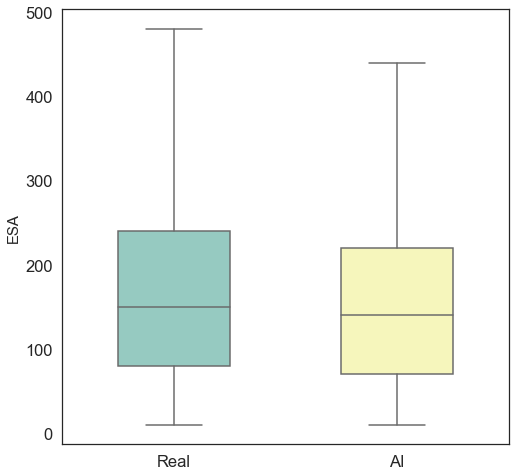

ESA T-test p-value: 0.00045937593036279086


In [143]:
a, b = equal_sample_size(non_zero_esa_amount_real_test, non_zero_esa_amount_ai_test)
non_esa_amount_test = pd.DataFrame({'Real': a, 'AI': b})
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=non_esa_amount_test, width=0.5, palette="Set3", showfliers=False)
plt.savefig('ESA_Dose_BoxPlot - Test',dpi=1000)
plt.ylabel('ESA', fontsize=15)
plt.show()
print('ESA T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_test, non_zero_esa_amount_ai_test).pvalue)

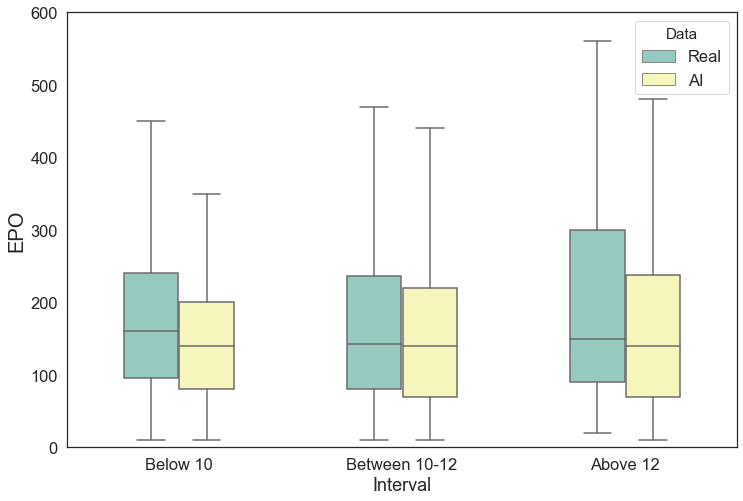

All
All Instances: 1395
ESA - Real: 179.35060975609755 132.38813363159653
ESA - AI: 160.209324452902 113.31336251423298
T-test p-value: 0.00045937593036279086
--------------------
Below 10
All Instances: 278
Instances (EPO > 0) - Real: 167
ESA (Mean/Std) - Real: 177.3 / 124.4
ESA (IQR)- Real: [ 95. 160. 240.]
Instances (EPO > 0) - AI: 178
ESA (Mean/Std) - AI: 152.8 / 99.9
ESA (IQR)- AI: [ 80. 140. 200.]
T-test p-value (Real vs AI): 0.04394095964772117
--------------------
Between 10-12
All Instances: 970
Instances (EPO > 0) - Real: 695
ESA (Mean/Std) - Real: 165.7 / 123.9
ESA (IQR)- Real: [ 80. 125. 220.]
Instances (EPO > 0) - AI: 731
ESA (Mean/Std) - AI: 145.9 / 107.6
ESA (IQR)- AI: [ 70. 120. 190.]
T-test p-value (Real vs AI): 0.0012597570746599237
--------------------
Above 12
All Instances: 147
Instances (EPO > 0) - Real: 67
ESA (Mean/Std) - Real: 70.5 / 79.9
ESA (IQR)- Real: [30. 60. 80.]
Instances (EPO > 0) - AI: 76
ESA (Mean/Std) - AI: 40.5 / 35.7
ESA (IQR)- AI: [10. 25. 60.]
T-

In [155]:
fixed_length_non_zero_esa_amount_real_test = [np.nan]*(len(Hb_variability_interval_test) - len(non_zero_esa_amount_real_test)) + non_zero_esa_amount_real_test.tolist() 
fixed_length_non_zero_esa_amount_ai_test = [np.nan]*(len(Hb_variability_interval_test) - len(non_zero_esa_amount_ai_test)) + non_zero_esa_amount_ai_test.tolist()
recommended_epo_by_interval_test = pd.DataFrame({'Interval': Hb_variability_interval_test + Hb_variability_interval_test, 
                                                'EPO': fixed_length_non_zero_esa_amount_real_test + fixed_length_non_zero_esa_amount_ai_test,
                                                 'Data': ['Real']*len(Hb_variability_interval_test) + ['AI']*len(Hb_variability_interval_test)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="EPO", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=recommended_epo_by_interval_test, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('EPO', fontsize=20)
plt.ylim(0, 600)
plt.savefig('Recommended_ESA_Dose_BoxPlot - Test',dpi=1000)
plt.show()
print('All')
print('All Instances:', len(Hb_variability_interval_test))
print('ESA - Real:', np.mean(non_zero_esa_amount_real_test), np.std(non_zero_esa_amount_real_test))
print('ESA - AI:', np.mean(non_zero_esa_amount_ai_test), np.std(non_zero_esa_amount_ai_test))
print('T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_test, non_zero_esa_amount_ai_test).pvalue)
print('--------------------')
print('Below 10')
print('All Instances:', len([i for i in Hb_variability_interval_test if i =='Below 10']))
recommended_non_zero_real_epo_non_na_below10_test = [e for i, e in zip(Hb_variability_interval_test, fixed_length_non_zero_esa_amount_real_test) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_below10_test))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_below10_test).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_below10_test).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_below10_test, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_below10_test = [e for i, e in zip(Hb_variability_interval_test, fixed_length_non_zero_esa_amount_ai_test) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_below10_test))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_below10_test).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_below10_test).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_below10_test, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_below10_test, recommended_non_zero_ai_epo_non_na_below10_test).pvalue)
print('--------------------')
print('Between 10-12')
print('All Instances:', len([i for i in Hb_variability_interval_test if i =='Between 10-12']))
recommended_non_zero_real_epo_non_na_btw1012_test = [e for i, e in zip(Hb_variability_interval_test, non_zero_real_epo_test) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_btw1012_test))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_btw1012_test).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_btw1012_test).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_btw1012_test, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_btw1012_test = [e for i, e in zip(Hb_variability_interval_test, non_zero_ai_epo_test) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_btw1012_test))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_btw1012_test).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_btw1012_test).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_btw1012_test, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_btw1012_test, recommended_non_zero_ai_epo_non_na_btw1012_test).pvalue)
print('--------------------')
print('Above 12')
print('All Instances:', len([i for i in Hb_variability_interval_test if i =='Above 12']))
recommended_non_zero_real_epo_non_na_above12_test = [e for i, e in zip(Hb_variability_interval_test, non_zero_real_epo_test) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_above12_test))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_above12_test).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_above12_test).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_above12_test, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_above12_test = [e for i, e in zip(Hb_variability_interval_test, non_zero_ai_epo_test) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_above12_test))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_above12_test).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_test).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_above12_test, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_above12_test, recommended_non_zero_ai_epo_non_na_above12_test).pvalue)

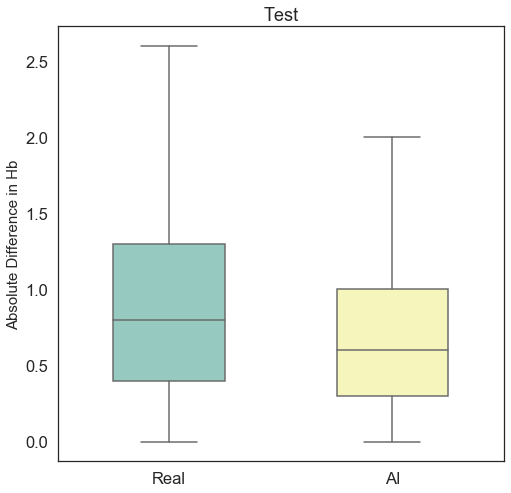

T-test p-value: 7.727830719151785e-24


In [128]:
Hb_variability_test = pd.DataFrame({'Real': np.abs(Hb_variability_real_test), 'AI': np.abs(Hb_variability_ai_test)})
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=Hb_variability_test, width=0.5, palette="Set3", showfliers=False)
plt.title('Test')
plt.ylabel('Absolute Difference in Hb', fontsize=15)
plt.savefig('Hb_Variability_BoxPlot - Test',dpi=1000)
plt.show()
print('T-test p-value:', stats.ttest_ind(np.abs(Hb_variability_real_test), np.abs(Hb_variability_ai_test)).pvalue)

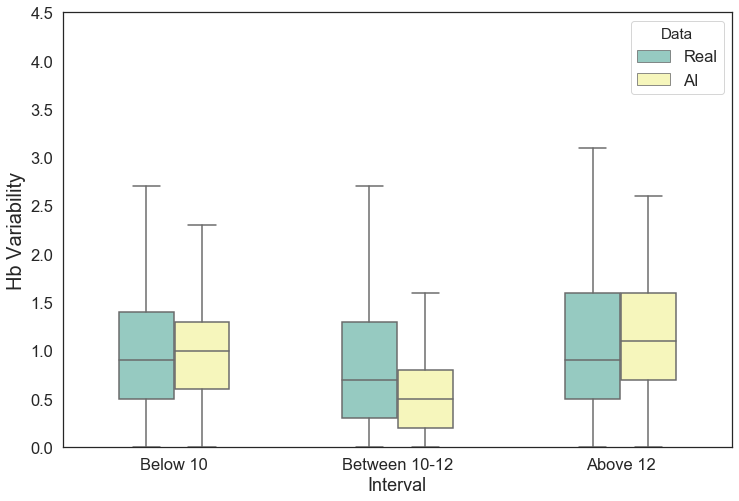

Counter({'Between 10-12': 970, 'Below 10': 278, 'Above 12': 147})
1395


In [119]:
Hb_variability_by_interval_test = pd.DataFrame({'Interval': Hb_variability_interval_test+Hb_variability_interval_test, 
                                                 'Hb_variability': np.abs(Hb_variability_real_test+Hb_variability_ai_test), 
                                                 'Data': ['Real']*len(Hb_variability_real_test) + ['AI']*len(Hb_variability_ai_test)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="Hb_variability", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=Hb_variability_by_interval_test, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('Hb Variability', fontsize=20)
plt.ylim(0, 4.5)
plt.savefig('Hb_Variability_BoxPlot_Interval - Test',dpi=1000)
plt.show()
print(Counter(Hb_variability_interval_test))
print(len(Hb_variability_interval_test))

## All

In [146]:
Hb_variability_real_all = Hb_variability_real_train + Hb_variability_real_valid + Hb_variability_real_test
Hb_variability_ai_all = Hb_variability_ai_train + Hb_variability_ai_valid + Hb_variability_ai_test
Hb_variability_interval_all = Hb_variability_interval_train + Hb_variability_interval_valid + Hb_variability_interval_test
esa_amount_real_all = esa_amount_real_train + esa_amount_real_valid+ esa_amount_real_test
esa_amount_ai_all = esa_amount_ai_train + esa_amount_ai_valid +  esa_amount_ai_test

success_real_below10_all = success_real_below10_train + success_real_below10_valid + success_real_below10_test
fail_real_below10_all = fail_real_below10_train + fail_real_below10_valid + fail_real_below10_test
success_ai_below10_all = success_ai_below10_train + success_ai_below10_valid + success_ai_below10_test
fail_ai_below10_all = fail_ai_below10_train + fail_ai_below10_valid + fail_ai_below10_test

overcor_real_btw1012_all = overcor_real_btw1012_train + overcor_real_btw1012_valid + overcor_real_btw1012_test
success_real_btw1012_all = success_real_btw1012_train + success_real_btw1012_valid + success_real_btw1012_test
fail_real_btw1012_all = fail_real_btw1012_train + fail_real_btw1012_valid + fail_real_btw1012_test
overcor_ai_btw1012_all = overcor_ai_btw1012_train + overcor_ai_btw1012_valid + overcor_ai_btw1012_test
success_ai_btw1012_all = success_ai_btw1012_train + success_ai_btw1012_valid + success_ai_btw1012_test
fail_ai_btw1012_all = fail_ai_btw1012_train + fail_ai_btw1012_valid + fail_ai_btw1012_test

In [147]:
print('Hb Variability(mean) - Doctors:', np.mean(np.abs(Hb_variability_real_all)).round(2)) 
print('Hb Variability(mean) - AI:', np.mean(np.abs(Hb_variability_ai_all)).round(2))
print('Hb Variability(std) - Doctors:', np.std(np.abs(Hb_variability_real_all)).round(2)) 
print('Hb Variability(std) - AI:', np.std(np.abs(Hb_variability_ai_all)).round(2))
print('Hb Variability(IQR) - Real:', np.percentile(np.abs(Hb_variability_real_all), q=[25,50,75]).round(2))
print('Hb Variability(IQR) - AI:', np.percentile(np.abs(Hb_variability_ai_all), q=[25,50,75]).round(2))
print('-----------------') 
print('-----------------')
non_zero_esa_amount_real_all = np.array([i for i in esa_amount_real_all if i!=0])
non_zero_esa_amount_ai_all = np.array([i for i in esa_amount_ai_all if i!=0])
print('All Data - Doctors:', len(Hb_variability_ai_all))
print('All Data - AI:', len(Hb_variability_ai_all))
print('EPO Valid Data - Doctors:', len(non_zero_esa_amount_real_all))
print('EPO Valid Data - AI:', len(non_zero_esa_amount_ai_all))
print('-----------------')
print('IQR - Real:', np.percentile(non_zero_esa_amount_real_all, q=[25,50,75]))
print('Mean - Real:', np.mean(non_zero_esa_amount_real_all).round(2))
print('Std - Real:', np.std(non_zero_esa_amount_real_all).round(2))
print('Instances - Real:', len(non_zero_esa_amount_real_all))
print('Total ESA Used - Real:', sum(non_zero_esa_amount_real_all))
print('-----------------')
print('IQR - AI:', np.percentile(non_zero_esa_amount_ai_all, q=[25, 50, 75]))
print('Mean - AI:', np.mean(non_zero_esa_amount_ai_all).round(2))
print('Std - AI:', np.std(non_zero_esa_amount_ai_all).round(2))
print('Instances - AI:', len(non_zero_esa_amount_ai_all))
print('Total ESA Used - AI:', sum(non_zero_esa_amount_ai_all))
print('-----------------')
print('-----------------')
print('Below 10')
print('Instances - Doctors:', len(success_real_below10_all)+len(fail_real_below10_all))
print('Instances - AI:', len(success_ai_below10_all)+len(fail_ai_below10_all))
non_zero_success_real_below10_all = np.array([i for i in success_real_below10_all if i!=0])
non_zero_fail_real_below10_all = np.array([i for i in fail_real_below10_all if i!=0])
non_zero_success_ai_below10_all = np.array([i for i in success_ai_below10_all if i!=0])
non_zero_fail_ai_below10_all = np.array([i for i in fail_ai_below10_all if i!=0])
print('Success Rate - Doctors:', len(success_real_below10_all), '|', np.round(len(success_real_below10_all)/(len(success_real_below10_all)+len(fail_real_below10_all))*100,1),'% |', len(success_real_below10_all))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_below10_all).round(2), '/', np.std(non_zero_success_real_below10_all).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_below10_all, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_below10_all), '|', np.round(len(success_ai_below10_all)/(len(success_ai_below10_all)+len(fail_ai_below10_all))*100,1),'% |', len(success_ai_below10_all))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_below10_all).round(2), '/', np.std(non_zero_success_ai_below10_all).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_below10_all, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_below10_all, non_zero_success_ai_below10_all).pvalue)
print('Failure Rate - Doctors:', len(fail_real_below10_all), '|', np.round(len(fail_real_below10_all)/(len(success_real_below10_all)+len(fail_real_below10_all))*100,1),'% |', len(fail_real_below10_all))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_below10_all).round(2), '/', np.std(non_zero_fail_real_below10_all).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_below10_all, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_below10_all), '|', np.round(len(fail_ai_below10_all)/(len(success_ai_below10_all)+len(fail_ai_below10_all))*100,1),'% |', len(fail_ai_below10_all))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_below10_all).round(2), '/', np.std(non_zero_fail_ai_below10_all).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_below10_all, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_below10_all, non_zero_fail_ai_below10_all).pvalue)
print('-----------------')
print('Between 10 - 12')
print('Instances - Doctors:', len(overcor_real_btw1012_all)+len(success_real_btw1012_all)+len(fail_real_btw1012_all))
print('Instances - AI:', len(overcor_ai_btw1012_all)+len(success_ai_btw1012_all)+len(fail_ai_btw1012_all))
non_zero_overcor_real_btw1012_all = np.array([i for i in overcor_real_btw1012_all if i!=0])
non_zero_success_real_btw1012_all = np.array([i for i in success_real_btw1012_all if i!=0])
non_zero_fail_real_btw1012_all = np.array([i for i in fail_real_btw1012_all if i!=0])
non_zero_overcor_ai_btw1012_all = np.array([i for i in overcor_ai_btw1012_all if i!=0])
non_zero_success_ai_btw1012_all = np.array([i for i in success_ai_btw1012_all if i!=0])
non_zero_fail_ai_btw1012_all = np.array([i for i in fail_ai_btw1012_all if i!=0])
print('Overcor Rate - Doctors:', len(overcor_real_btw1012_all), '|', np.round(len(overcor_real_btw1012_all)/(len(overcor_real_btw1012_all)+len(success_real_btw1012_all)+len(fail_real_btw1012_all))*100,1),'% |', len(overcor_real_btw1012_all))
print('Overcor Rate (Mean/Std) - Doctors:', np.mean(non_zero_overcor_real_btw1012_all).round(2), '/', np.std(non_zero_overcor_real_btw1012_all).round(2))
print('Overcor Rate (IQR) - Doctors:', np.percentile(non_zero_overcor_real_btw1012_all, q=[25, 50, 75]))
print('Overcor Rate - AI:', len(overcor_ai_btw1012_all), '|', np.round(len(overcor_ai_btw1012_all)/(len(overcor_ai_btw1012_all)+len(success_ai_btw1012_all)+len(fail_ai_btw1012_all))*100,1),'% |', len(overcor_ai_btw1012_all))
print('Overcor Rate (Mean/Std) - AI:', np.mean(non_zero_overcor_ai_btw1012_all).round(2), '/', np.std(non_zero_overcor_ai_btw1012_all).round(2))
print('Overcor Rate (IQR) - AI:', np.percentile(non_zero_overcor_ai_btw1012_all, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_overcor_real_btw1012_all, non_zero_overcor_ai_btw1012_all).pvalue)
print('Success Rate - Doctors:', len(success_real_btw1012_all), '|', np.round(len(success_real_btw1012_all)/(len(overcor_real_btw1012_all)+len(success_real_btw1012_all)+len(fail_real_btw1012_all))*100,1),'% |', len(success_real_btw1012_all))
print('Success Rate (Mean/Std) - Doctors:', np.mean(non_zero_success_real_btw1012_all).round(2), '/', np.std(non_zero_success_real_btw1012_all).round(2))
print('Success Rate (IQR) - Doctors:', np.percentile(non_zero_success_real_btw1012_all, q=[25, 50, 75]))
print('Success Rate - AI:', len(success_ai_btw1012_all), '|', np.round(len(success_ai_btw1012_all)/(len(overcor_ai_btw1012_all)+len(success_ai_btw1012_all)+len(fail_ai_btw1012_all))*100,1),'% |', len(success_ai_btw1012_all))
print('Success Rate (Mean/Std) - AI:', np.mean(non_zero_success_ai_btw1012_all).round(2), '/', np.std(non_zero_success_ai_btw1012_all).round(2))
print('Success Rate (IQR) - AI:', np.percentile(non_zero_success_ai_btw1012_all, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_success_real_btw1012_all, non_zero_success_ai_btw1012_all).pvalue)
print('Failure Rate - Doctors:', len(fail_real_btw1012_all), '|', np.round(len(fail_real_btw1012_all)/(len(overcor_real_btw1012_all)+len(success_real_btw1012_all)+len(fail_real_btw1012_all))*100,1),'% |', len(fail_real_btw1012_all))
print('Failure Rate (Mean/Std) - Doctors:', np.mean(non_zero_fail_real_btw1012_all).round(2), '/', np.std(non_zero_fail_real_btw1012_all).round(2))
print('Failure Rate (IQR) - Doctors:', np.percentile(non_zero_fail_real_btw1012_all, q=[25, 50, 75]))
print('Failure Rate - AI:', len(fail_ai_btw1012_all), '|', np.round(len(fail_ai_btw1012_all)/(len(overcor_ai_btw1012_all)+len(success_ai_btw1012_all)+len(fail_ai_btw1012_all))*100,1),'% |', len(fail_ai_btw1012_all))
print('Failure Rate (Mean/Std) - AI:', np.mean(non_zero_fail_ai_btw1012_all).round(2), '/', np.std(non_zero_fail_ai_btw1012_all).round(2))
print('Failure Rate (IQR) - AI:', np.percentile(non_zero_fail_ai_btw1012_all, q=[25, 50, 75]))
print('T-test p-value:', stats.ttest_ind(non_zero_fail_real_btw1012_all, non_zero_fail_ai_btw1012_all).pvalue)
print('-----------------')

Hb Variability(mean) - Doctors: 0.94
Hb Variability(mean) - AI: 0.68
Hb Variability(std) - Doctors: 0.74
Hb Variability(std) - AI: 0.53
Hb Variability(IQR) - Real: [0.4 0.8 1.4]
Hb Variability(IQR) - AI: [0.3 0.6 1. ]
-----------------
-----------------
All Data - Doctors: 12897
All Data - AI: 12897
EPO Valid Data - Doctors: 8527
EPO Valid Data - AI: 9496
-----------------
IQR - Real: [ 80. 155. 240.]
Mean - Real: 176.46
Std - Real: 125.58
Instances - Real: 8527
Total ESA Used - Real: 1504717.0
-----------------
IQR - AI: [ 70. 140. 210.]
Mean - AI: 152.73
Std - AI: 105.65
Instances - AI: 9496
Total ESA Used - AI: 1450320
-----------------
-----------------
Below 10
Instances - Doctors: 2723
Instances - AI: 2723
Success Rate - Doctors: 1743 | 64.0 % | 1743
Success Rate (Mean/Std) - Doctors: 258.81 / 131.08
Success Rate (IQR) - Doctors: [160. 240. 320.]
Success Rate - AI: 2095 | 76.9 % | 2095
Success Rate (Mean/Std) - AI: 231.91 / 100.5
Success Rate (IQR) - AI: [170. 220. 280.]
T-test p

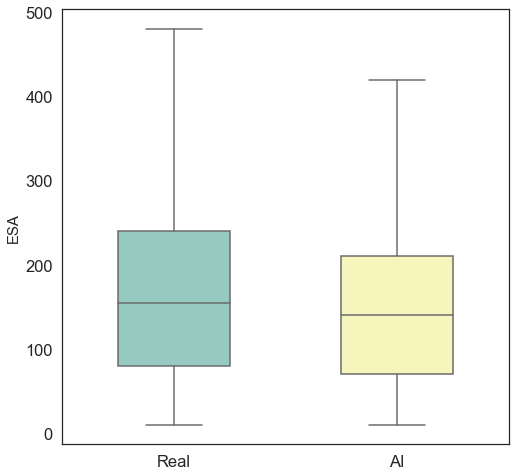

ESA T-test p-value: 6.159715100147036e-43


In [148]:
a, b = equal_sample_size(non_zero_esa_amount_real_all, non_zero_esa_amount_ai_all)
non_esa_amount_all = pd.DataFrame({'Real': a, 'AI': b})
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=non_esa_amount_all, width=0.5, palette="Set3", showfliers=False)
plt.savefig('ESA_Dose_BoxPlot - All',dpi=1000)
plt.ylabel('ESA', fontsize=15)
plt.show()
print('ESA T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_all, non_zero_esa_amount_ai_all).pvalue)

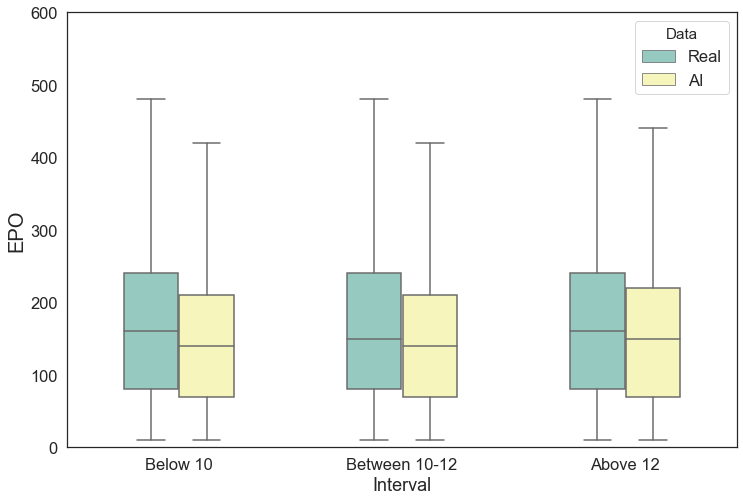

All
All Instances: 12897
ESA - Real: 176.46499354990033 125.58103229642953
ESA - AI: 152.7295703454086 105.64991700821328
T-test p-value: 6.159715100147036e-43
--------------------
Below 10
All Instances: 2723
Instances (EPO > 0) - Real: 1682
ESA (Mean/Std) - Real: 174.5 / 122.9
ESA (IQR)- Real: [ 80. 160. 240.]
Instances (EPO > 0) - AI: 1902
ESA (Mean/Std) - AI: 151.4 / 101.7
ESA (IQR)- AI: [ 70. 140. 210.]
T-test p-value (Real vs AI): 9.065118589945478e-10
--------------------
Between 10-12
All Instances: 8609
Instances (EPO > 0) - Real: 5828
ESA (Mean/Std) - Real: 157.1 / 112.9
ESA (IQR)- Real: [ 80. 130. 200.]
Instances (EPO > 0) - AI: 6361
ESA (Mean/Std) - AI: 132.6 / 98.6
ESA (IQR)- AI: [ 60. 120. 180.]
T-test p-value (Real vs AI): 3.2022062772618718e-37
--------------------
Above 12
All Instances: 1565
Instances (EPO > 0) - Real: 503
ESA (Mean/Std) - Real: 68.7 / 53.8
ESA (IQR)- Real: [40. 60. 80.]
Instances (EPO > 0) - AI: 585
ESA (Mean/Std) - AI: 41.0 / 34.3
ESA (IQR)- AI: [10

In [150]:
fixed_length_non_zero_esa_amount_real_all = [np.nan]*(len(Hb_variability_interval_all) - len(non_zero_esa_amount_real_all)) + non_zero_esa_amount_real_all.tolist() 
fixed_length_non_zero_esa_amount_ai_all = [np.nan]*(len(Hb_variability_interval_all) - len(non_zero_esa_amount_ai_all)) + non_zero_esa_amount_ai_all.tolist()
recommended_epo_by_interval_all = pd.DataFrame({'Interval': Hb_variability_interval_all + Hb_variability_interval_all, 
                                                'EPO': fixed_length_non_zero_esa_amount_real_all + fixed_length_non_zero_esa_amount_ai_all,
                                                 'Data': ['Real']*len(Hb_variability_interval_all) + ['AI']*len(Hb_variability_interval_all)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="EPO", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=recommended_epo_by_interval_all, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('EPO', fontsize=20)
plt.ylim(0, 600)
plt.savefig('Recommended_ESA_Dose_BoxPlot - All',dpi=1000)
plt.show()
print('All')
print('All Instances:', len(Hb_variability_interval_all))
print('ESA - Real:', np.mean(non_zero_esa_amount_real_all), np.std(non_zero_esa_amount_real_all))
print('ESA - AI:', np.mean(non_zero_esa_amount_ai_all), np.std(non_zero_esa_amount_ai_all))
print('T-test p-value:', stats.ttest_ind(non_zero_esa_amount_real_all, non_zero_esa_amount_ai_all).pvalue)
print('--------------------')
print('Below 10')
print('All Instances:', len([i for i in Hb_variability_interval_all if i =='Below 10']))
recommended_non_zero_real_epo_non_na_below10_all = [e for i, e in zip(Hb_variability_interval_all, fixed_length_non_zero_esa_amount_real_all) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_below10_all))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_below10_all).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_below10_all).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_below10_all, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_below10_all = [e for i, e in zip(Hb_variability_interval_all, fixed_length_non_zero_esa_amount_ai_all) if i =='Below 10' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_below10_all))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_below10_all).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_below10_all).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_below10_all, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_below10_all, recommended_non_zero_ai_epo_non_na_below10_all).pvalue)
print('--------------------')
print('Between 10-12')
print('All Instances:', len([i for i in Hb_variability_interval_all if i =='Between 10-12']))
recommended_non_zero_real_epo_non_na_btw1012_all = [e for i, e in zip(Hb_variability_interval_all, non_zero_real_epo_all) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_btw1012_all))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_btw1012_all).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_btw1012_all).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_btw1012_all, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_btw1012_all = [e for i, e in zip(Hb_variability_interval_all, non_zero_ai_epo_all) if i =='Between 10-12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_btw1012_all))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_btw1012_all).round(1), '/', np.std(recommended_non_zero_ai_epo_non_na_btw1012_all).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_btw1012_all, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_btw1012_all, recommended_non_zero_ai_epo_non_na_btw1012_all).pvalue)
print('--------------------')
print('Above 12')
print('All Instances:', len([i for i in Hb_variability_interval_all if i =='Above 12']))
recommended_non_zero_real_epo_non_na_above12_all = [e for i, e in zip(Hb_variability_interval_all, non_zero_real_epo_all) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - Real:', len(recommended_non_zero_real_epo_non_na_above12_all))
print('ESA (Mean/Std) - Real:', np.mean(recommended_non_zero_real_epo_non_na_above12_all).round(1), '/', np.std(recommended_non_zero_real_epo_non_na_above12_all).round(1))
print('ESA (IQR)- Real:',  np.percentile(recommended_non_zero_real_epo_non_na_above12_all, q=[25, 50, 75]).round(1))
recommended_non_zero_ai_epo_non_na_above12_all = [e for i, e in zip(Hb_variability_interval_all, non_zero_ai_epo_all) if i =='Above 12' and not np.isnan(e)]
print('Instances (EPO > 0) - AI:', len(recommended_non_zero_ai_epo_non_na_above12_all))
print('ESA (Mean/Std) - AI:', np.mean(recommended_non_zero_ai_epo_non_na_above12_all).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_all).round(1))
print('ESA (IQR)- AI:',  np.percentile(recommended_non_zero_ai_epo_non_na_above12_all, q=[25, 50, 75]).round(1))
print('T-test p-value (Real vs AI):', stats.ttest_ind(recommended_non_zero_real_epo_non_na_above12_all, recommended_non_zero_ai_epo_non_na_above12_all).pvalue)

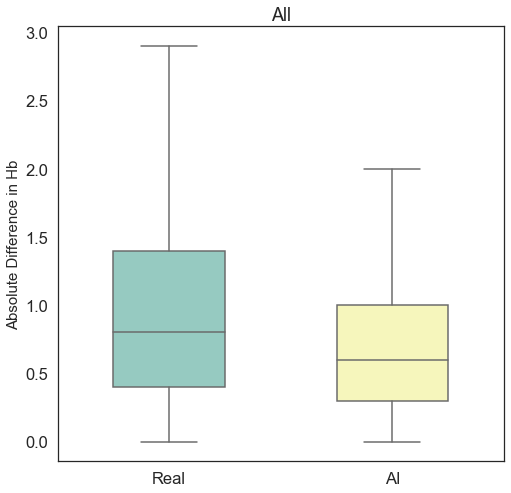

T-test p-value: 6.005236032190419e-224


In [129]:
Hb_variability_all = pd.DataFrame({'Real': np.abs(Hb_variability_real_all), 'AI': np.abs(Hb_variability_ai_all)})
plt.rcParams["figure.figsize"] = (8,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=Hb_variability_all, width=0.5, palette="Set3", showfliers=False)
plt.title('All')
plt.ylabel('Absolute Difference in Hb', fontsize=15)
plt.savefig('Hb_Variability_BoxPlot - All',dpi=1000)
plt.show()
print('T-test p-value:', stats.ttest_ind(np.abs(Hb_variability_real_all), np.abs(Hb_variability_ai_all)).pvalue)

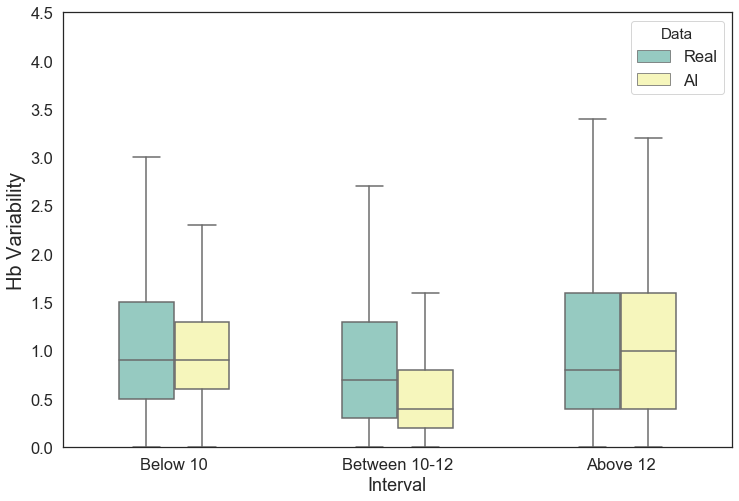

Counter({'Between 10-12': 8609, 'Below 10': 2723, 'Above 12': 1565})
12897


In [124]:
Hb_variability_by_interval_all = pd.DataFrame({'Interval': Hb_variability_interval_all+Hb_variability_interval_all, 
                                                 'Hb_variability': np.abs(Hb_variability_real_all+Hb_variability_ai_all), 
                                                 'Data': ['Real']*len(Hb_variability_real_all) + ['AI']*len(Hb_variability_ai_all)
                                                })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="Hb_variability", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=Hb_variability_by_interval_all, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('Hb Variability', fontsize=20)
plt.ylim(0, 4.5)
plt.savefig('Hb_Variability_BoxPlot_Interval - All',dpi=1000)
plt.show()
print(Counter(Hb_variability_interval_all))
print(len(Hb_variability_interval_all))

# Recommendation Model Sensitivity Analysis - 구간별 ESA Error

## Train

In [24]:
epo_diff_train = []
real_epo_train = []
ai_epo_train = []

below10_t1_train = []
betw1012_t1_train = []
above12_t1_train = []

below10_t0_train = []
betw1012_t0_train = []
above12_t0_train = []

ESA_sensitivity_interval_t0_train = []
ESA_sensitivity_interval_t1_train = []

success_real_epo_train = []
success_ai_epo_train = []
failure_real_epo_train = []

for p in tqdm(train_patient):
    
    x = temp[temp['Study_Subject_Number']==p]
    y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values
    if len(x)>seq_len:
        order = x['Order'].values       
        x = trn_scaler_mean.transform(x[trn_vars])
        for i in range(seq_len, len(x)+1):
            
            x_ = x[i-seq_len:i] # normalized
            
            prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
            prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
            prev_epo = np.abs(prev_epo)

            cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
            cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
            cur_epo = np.abs(cur_epo)
            next_hb = y[i-1] # 10

            target_y = np.array([next_hb]) # 10
            target_y_normalized = transform_target_hb(target_y) # normalized

            past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
            epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9

            epo_pred = ans_process(epo_pred)[0] # 400
            epo_pred_normalized = transform_epo(epo_pred)
            
            x_temp = x_.copy()
            x_temp[-1,epo_idx] = epo_pred_normalized
            
            hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp]))).round(1)
            
            epo_diff_train.append(cur_epo - epo_pred)
            real_epo_train.append(cur_epo)
            ai_epo_train.append(epo_pred)
            if next_hb < 10:
                below10_t1_train.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_train.append('Below 10')
            elif next_hb >= 10 and next_hb <= 12:
                betw1012_t1_train.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_train.append('Between 10-12')
            else:
                above12_t1_train.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_train.append('Above 12')
                
            if cur_hb < 10:
                below10_t0_train.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_train.append('Below 10')
            elif cur_hb >= 10 and cur_hb <= 12:
                betw1012_t0_train.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_train.append('Between 10-12')
            else:
                above12_t0_train.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_train.append('Above 12')
                
            if cur_hb < 10 and next_hb >= 10:
                success_real_epo_train.append(cur_epo)
            elif cur_hb < 10 and next_hb < 10:
                failure_real_epo_train.append(cur_epo)                         
            if cur_hb < 10 and hb_AI[0][0] >= 10:
                success_ai_epo_train.append(epo_pred)

100%|████████████████████████████████| 372/372 [01:49<00:00,  3.80it/s]


In [25]:
print('All:', len(epo_diff_train), '| Acc: ', np.mean(np.abs(epo_diff_train)).round(4)) 

print('---------------')
print('Invervals by Hb(t+1),')
below10_esa_error_t1_train = np.mean(np.abs(below10_t1_train)).round(4)
print('Below 10:', len(below10_t1_train), 
      '| Higher than MAE('+str(below10_esa_error_t1_train)+'):', 
      len([e for e in np.abs(below10_t1_train) if e > below10_esa_error_t1_train]),
      '| Lower than MAE('+str(below10_esa_error_t1_train)+'):',
      len([e for e in np.abs(below10_t1_train) if e <= below10_esa_error_t1_train])
     ) 
betw1012_esa_error_t1_train = np.mean(np.abs(betw1012_t1_train)).round(4)
print('10 - 12:', len(betw1012_t1_train), 
      '| Higher than MAE('+str(betw1012_esa_error_t1_train)+'):', 
      len([e for e in np.abs(betw1012_t1_train) if e > betw1012_esa_error_t1_train]),
      '| Lower than MAE('+str(betw1012_esa_error_t1_train)+'):',
      len([e for e in np.abs(betw1012_t1_train) if e <= betw1012_esa_error_t1_train])
     ) 
above12_esa_error_t1_train = np.mean(np.abs(above12_t1_train)).round(4)
print('Above 12:', len(above12_t1_train), 
      '| Higher than MAE('+str(above12_esa_error_t1_train)+'):', 
      len([e for e in np.abs(above12_t1_train) if e > above12_esa_error_t1_train]),
      '| Lower than MAE('+str(above12_esa_error_t1_train)+'):',
      len([e for e in np.abs(above12_t1_train) if e <= above12_esa_error_t1_train])
     )

print('---------------')
print('Invervals by Hb(t),')
below10_esa_error_t0_train = np.mean(np.abs(below10_t0_train)).round(4)
print('Below 10:', len(below10_t0_train), 
      '| Higher than MAE('+str(below10_esa_error_t0_train)+'):', 
      len([e for e in np.abs(below10_t0_train) if e > below10_esa_error_t0_train]),
      '| Lower than MAE('+str(below10_esa_error_t0_train)+'):',
      len([e for e in np.abs(below10_t0_train) if e <= below10_esa_error_t0_train])
     ) 
betw1012_esa_error_t0_train = np.mean(np.abs(betw1012_t0_train)).round(4)
print('10 - 12:', len(betw1012_t0_train), 
      '| Higher than MAE('+str(betw1012_esa_error_t0_train)+'):', 
      len([e for e in np.abs(betw1012_t0_train) if e > betw1012_esa_error_t0_train]),
      '| Lower than MAE('+str(betw1012_esa_error_t0_train)+'):',
      len([e for e in np.abs(betw1012_t0_train) if e <= betw1012_esa_error_t0_train])
     ) 
above12_esa_error_t0_train = np.mean(np.abs(above12_t0_train)).round(4)
print('Above 12:', len(above12_t0_train), 
      '| Higher than MAE('+str(above12_esa_error_t0_train)+'):', 
      len([e for e in np.abs(above12_t0_train) if e > above12_esa_error_t0_train]),
      '| Lower than MAE('+str(above12_esa_error_t0_train)+'):',
      len([e for e in np.abs(above12_t0_train) if e <= above12_esa_error_t0_train])
     )

All: 10314 | Acc:  39.2184
---------------
Invervals by Hb(t+1),
Below 10: 2216 | Higher than MAE(42.4052): 737 | Lower than MAE(42.4052): 1479
10 - 12: 6838 | Higher than MAE(39.2002): 2624 | Lower than MAE(39.2002): 4214
Above 12: 1260 | Higher than MAE(33.7127): 382 | Lower than MAE(33.7127): 878
---------------
Invervals by Hb(t),
Below 10: 2181 | Higher than MAE(57.619): 843 | Lower than MAE(57.619): 1338
10 - 12: 6860 | Higher than MAE(37.9106): 2571 | Lower than MAE(37.9106): 4289
Above 12: 1273 | Higher than MAE(14.7408): 369 | Lower than MAE(14.7408): 904


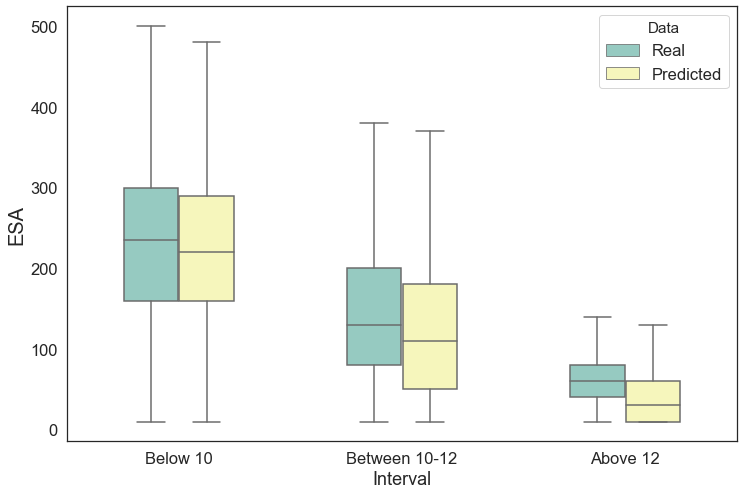

Below 10
All Instances: 2181
Instances (EPO > 0) - Real: 1757
ESA (Mean/Std) - Real: 251.1 / 128.2
ESA (IQR)- Real: [160. 235. 300.]
Instances (EPO > 0) - AI: 1789
ESA (Mean/Std) - AI: 235.2 / 111.4
ESA (IQR)- AI: [160. 220. 290.]
T-test p-value (Real vs AI): 8.00072972569984e-05
--------------------
Between 10-12
All Instances: 6860
Instances (EPO > 0) - Real: 4582
ESA (Mean/Std) - Real: 155.4 / 110.5
ESA (IQR)- Real: [ 80. 130. 200.]
Instances (EPO > 0) - AI: 5056
ESA (Mean/Std) - AI: 129.8 / 96.9
ESA (IQR)- AI: [ 50. 110. 180.]
T-test p-value (Real vs AI): 1.7555857195275095e-33
--------------------
Above 12
All Instances: 1273
Instances (EPO > 0) - Real: 392
ESA (Mean/Std) - Real: 67.9 / 47.3
ESA (IQR)- Real: [40. 60. 80.]
Instances (EPO > 0) - AI: 448
ESA (Mean/Std) - AI: 40.8 / 34.2
ESA (IQR)- AI: [10. 30. 60.]
T-test p-value (Real vs AI): 1.11528858522328e-20


In [47]:
non_zero_real_epo_train = [np.nan if e==0 else e for e in real_epo_train]
non_zero_ai_epo_train = [np.nan if e==0 else e for e in ai_epo_train] 
non_zero_real_epo_non_na_train = [e for e in non_zero_real_epo_train if not np.isnan(e)]
non_zero_ai_epo_non_na_train = [e for e in non_zero_ai_epo_train if not np.isnan(e)] 
esa_by_interval_train = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_train+ESA_sensitivity_interval_t0_train, 
                                      'ESA': non_zero_real_epo_train+non_zero_ai_epo_train,
                                      'Data': ['Real']*len(real_epo_train) + ['Predicted']*len(ai_epo_train),
                                      'MAE': np.abs(epo_diff_train + epo_diff_train)
                                               })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="ESA", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=esa_by_interval_train, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('ESA', fontsize=20)
plt.savefig('ESA_BoxPlot_Interval - Train',dpi=1000)
plt.show()
# print('ESA - Real:', np.mean(non_zero_real_epo_non_na_train), np.std(non_zero_real_epo_non_na_train))
# print('ESA - AI:', np.mean(non_zero_ai_epo_non_na_train), np.std(non_zero_ai_epo_non_na_train))
# print('T-test p-value:', stats.ttest_ind(non_zero_real_epo_non_na_train, non_zero_ai_epo_non_na_train).pvalue)
# print('Below 10')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_train if i =='Below 10']))
# non_zero_real_epo_non_na_below10_train = [e for i, e in zip(ESA_sensitivity_interval_t0_train, non_zero_real_epo_train) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_below10_train))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_below10_train).round(1), '/', np.std(non_zero_real_epo_non_na_below10_train).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_below10_train, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_below10_train = [e for i, e in zip(ESA_sensitivity_interval_t0_train, non_zero_ai_epo_train) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_below10_train))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_below10_train).round(1), '/', np.std(non_zero_ai_epo_non_na_below10_train).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_below10_train, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_below10_train, non_zero_ai_epo_non_na_below10_train).pvalue)
# print('--------------------')
# print('Between 10-12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_train if i =='Between 10-12']))
# non_zero_real_epo_non_na_btw1012_train = [e for i, e in zip(ESA_sensitivity_interval_t0_train, non_zero_real_epo_train) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_btw1012_train))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_btw1012_train).round(1), '/', np.std(non_zero_real_epo_non_na_btw1012_train).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_btw1012_train, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_btw1012_train = [e for i, e in zip(ESA_sensitivity_interval_t0_train, non_zero_ai_epo_train) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_btw1012_train))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_btw1012_train).round(1), '/', np.std(non_zero_ai_epo_non_na_btw1012_train).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_btw1012_train, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_btw1012_train, non_zero_ai_epo_non_na_btw1012_train).pvalue)
# print('--------------------')
# print('Above 12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_train if i =='Above 12']))
# non_zero_real_epo_non_na_above12_train = [e for i, e in zip(ESA_sensitivity_interval_t0_train, non_zero_real_epo_train) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_above12_train))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_above12_train).round(1), '/', np.std(non_zero_real_epo_non_na_above12_train).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_above12_train, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_above12_train = [e for i, e in zip(ESA_sensitivity_interval_t0_train, non_zero_ai_epo_train) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_above12_train))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_above12_train).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_train).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_above12_train, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_above12_train, non_zero_ai_epo_non_na_above12_train).pvalue)

In [32]:
# succ_fail_esa_by_interval_train = pd.DataFrame({
#                                               'ESA': success_real_epo_train+failure_real_epo_train+success_ai_epo_train+success_ai_epo_train,
#                                               'Succ/Fail': ['Success(Real)']*len(success_real_epo_train) + ['Failure(Real)']*len(failure_real_epo_train) +
#                                                            ['Success(Real)']*len(success_ai_epo_train) + ['Failure(Real)']*len(success_ai_epo_train),
#                                               'Data': ['Real']*len(success_real_epo_train) + ['Real']*len(failure_real_epo_train) +
#                                                       ['AI']*len(success_ai_epo_train) + ['AI']*len(success_ai_epo_train),
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Succ/Fail", y="ESA", hue="Data", order=['Success(Real)','Failure(Real)'],
#             data=succ_fail_esa_by_interval_train, palette="Set3", width=0.5, showfliers=False)
# plt.ylabel('ESA', fontsize=20)
# plt.ylim(0,800)
# plt.savefig('ESA_BoxPlot_Success_Failure - Train',dpi=1000)
# plt.show()
# print('ESA (Success - Real) Instances:', len(success_real_epo_train))
# print('ESA (Success - Real) Mean/Std:', np.mean(len(success_real_epo_train)).round(1), '/', np.std(success_real_epo_train).round(1))
# print('ESA (Success - Real) IQR:',  np.percentile(success_real_epo_train, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_train))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_train).round(1),'/',  np.std(success_ai_epo_train).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_train, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Succ-Real vs Succ-AI ):', stats.ttest_ind(success_real_epo_train, success_ai_epo_train).pvalue)
# print('--------------------')
# print('ESA (Failure - Real) Instances:', len(failure_real_epo_train))
# print('ESA (Failure - Real) Mean/Std:', np.mean(failure_real_epo_train).round(1), '/', np.std(failure_real_epo_train).round(1))
# print('ESA (Failure - Real) IQR:',  np.percentile(failure_real_epo_train, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_train))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_train).round(1),'/',  np.std(success_ai_epo_train).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_train, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Real-Fail vs Succ-AI ):', stats.ttest_ind(failure_real_epo_train, success_ai_epo_train).pvalue)




# esa_mse_by_interval_t0_train = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_train+ESA_sensitivity_interval_t0_train, 
#                                           'MAE': np.abs(epo_diff_train + epo_diff_train)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t0_train, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t0_train.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t0_Interval - Train',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t0_train))
# print(len(ESA_sensitivity_interval_t0_train))



# esa_mse_by_interval_t1_train = pd.DataFrame({'Interval': ESA_sensitivity_interval_t1_train+ESA_sensitivity_interval_t1_train, 
#                                           'MAE': np.abs(epo_diff_train + epo_diff_train)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t1_train, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t1_train.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t1_Interval - Train',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t1_train))
# print(len(ESA_sensitivity_interval_t1_train))

## Valid

In [31]:
epo_diff_valid = []
real_epo_valid = []
ai_epo_valid = []

below10_t1_valid = []
betw1012_t1_valid = []
above12_t1_valid = []

below10_t0_valid = []
betw1012_t0_valid = []
above12_t0_valid = []

ESA_sensitivity_interval_t0_valid = []
ESA_sensitivity_interval_t1_valid = []

success_real_epo_valid = []
success_ai_epo_valid = []
failure_real_epo_valid = []

for p in tqdm(valid_patient):
    
    x = temp[temp['Study_Subject_Number']==p]
    y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values
    if len(x)>seq_len:
        order = x['Order'].values       
        x = trn_scaler_mean.transform(x[trn_vars])
        for i in range(seq_len, len(x)+1):
            
            x_ = x[i-seq_len:i] # normalized
            
            prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
            prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
            prev_epo = np.abs(prev_epo)

            cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
            cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
            cur_epo = np.abs(cur_epo)
            next_hb = y[i-1] # 10

            target_y = np.array([next_hb]) # 10
            target_y_normalized = transform_target_hb(target_y) # normalized

            past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
            epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9

            epo_pred = ans_process(epo_pred)[0] # 400
            epo_pred_normalized = transform_epo(epo_pred)
            
            x_temp = x_.copy()
            x_temp[-1,epo_idx] = epo_pred_normalized
            
            hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp]))).round(1)
            
            epo_diff_valid.append(cur_epo - epo_pred)
            real_epo_valid.append(cur_epo)
            ai_epo_valid.append(epo_pred)
            if next_hb < 10:
                below10_t1_valid.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_valid.append('Below 10')
            elif next_hb >= 10 and next_hb <= 12:
                betw1012_t1_valid.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_valid.append('Between 10-12')
            else:
                above12_t1_valid.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_valid.append('Above 12')
                
            if cur_hb < 10:
                below10_t0_valid.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_valid.append('Below 10')
            elif cur_hb >= 10 and cur_hb <= 12:
                betw1012_t0_valid.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_valid.append('Between 10-12')
            else:
                above12_t0_valid.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_valid.append('Above 12')
                
            if cur_hb < 10 and next_hb >= 10:
                success_real_epo_valid.append(cur_epo)
            elif cur_hb < 10 and next_hb < 10:
                failure_real_epo_valid.append(cur_epo)                         
            if cur_hb < 10 and hb_AI[0][0] >= 10:
                success_ai_epo_valid.append(epo_pred)

100%|██████████████████████████████████| 47/47 [00:12<00:00,  3.72it/s]


In [33]:
print('All:', len(epo_diff_valid), '| Acc: ', np.mean(np.abs(epo_diff_valid)).round(4)) 

print('---------------')
print('Invervals by Hb(t+1),')
below10_esa_error_t1_valid = np.mean(np.abs(below10_t1_valid)).round(4)
print('Below 10:', len(below10_t1_valid), 
      '| Higher than MAE('+str(below10_esa_error_t1_valid)+'):', 
      len([e for e in np.abs(below10_t1_valid) if e > below10_esa_error_t1_valid]),
      '| Lower than MAE('+str(below10_esa_error_t1_valid)+'):',
      len([e for e in np.abs(below10_t1_valid) if e <= below10_esa_error_t1_valid])
     ) 
betw1012_esa_error_t1_valid = np.mean(np.abs(betw1012_t1_valid)).round(4)
print('10 - 12:', len(betw1012_t1_valid), 
      '| Higher than MAE('+str(betw1012_esa_error_t1_valid)+'):', 
      len([e for e in np.abs(betw1012_t1_valid) if e > betw1012_esa_error_t1_valid]),
      '| Lower than MAE('+str(betw1012_esa_error_t1_valid)+'):',
      len([e for e in np.abs(betw1012_t1_valid) if e <= betw1012_esa_error_t1_valid])
     ) 
above12_esa_error_t1_valid = np.mean(np.abs(above12_t1_valid)).round(4)
print('Above 12:', len(above12_t1_valid), 
      '| Higher than MAE('+str(above12_esa_error_t1_valid)+'):', 
      len([e for e in np.abs(above12_t1_valid) if e > above12_esa_error_t1_valid]),
      '| Lower than MAE('+str(above12_esa_error_t1_valid)+'):',
      len([e for e in np.abs(above12_t1_valid) if e <= above12_esa_error_t1_valid])
     )

print('---------------')
print('Invervals by Hb(t),')
below10_esa_error_t0_valid = np.mean(np.abs(below10_t0_valid)).round(4)
print('Below 10:', len(below10_t0_valid), 
      '| Higher than MAE('+str(below10_esa_error_t0_valid)+'):', 
      len([e for e in np.abs(below10_t0_valid) if e > below10_esa_error_t0_valid]),
      '| Lower than MAE('+str(below10_esa_error_t0_valid)+'):',
      len([e for e in np.abs(below10_t0_valid) if e <= below10_esa_error_t0_valid])
     ) 
betw1012_esa_error_t0_valid = np.mean(np.abs(betw1012_t0_valid)).round(4)
print('10 - 12:', len(betw1012_t0_valid), 
      '| Higher than MAE('+str(betw1012_esa_error_t0_valid)+'):', 
      len([e for e in np.abs(betw1012_t0_valid) if e > betw1012_esa_error_t0_valid]),
      '| Lower than MAE('+str(betw1012_esa_error_t0_valid)+'):',
      len([e for e in np.abs(betw1012_t0_valid) if e <= betw1012_esa_error_t0_valid])
     ) 
above12_esa_error_t0_valid = np.mean(np.abs(above12_t0_valid)).round(4)
print('Above 12:', len(above12_t0_valid), 
      '| Higher than MAE('+str(above12_esa_error_t0_valid)+'):', 
      len([e for e in np.abs(above12_t0_valid) if e > above12_esa_error_t0_valid]),
      '| Lower than MAE('+str(above12_esa_error_t0_valid)+'):',
      len([e for e in np.abs(above12_t0_valid) if e <= above12_esa_error_t0_valid])
     )

All: 1188 | Acc:  43.0766
---------------
Invervals by Hb(t+1),
Below 10: 273 | Higher than MAE(46.9597): 100 | Lower than MAE(46.9597): 173
10 - 12: 774 | Higher than MAE(41.8217): 265 | Lower than MAE(41.8217): 509
Above 12: 141 | Higher than MAE(42.4468): 39 | Lower than MAE(42.4468): 102
---------------
Invervals by Hb(t),
Below 10: 264 | Higher than MAE(61.4205): 107 | Lower than MAE(61.4205): 157
10 - 12: 779 | Higher than MAE(41.887): 253 | Lower than MAE(41.887): 526
Above 12: 145 | Higher than MAE(16.069): 45 | Lower than MAE(16.069): 100


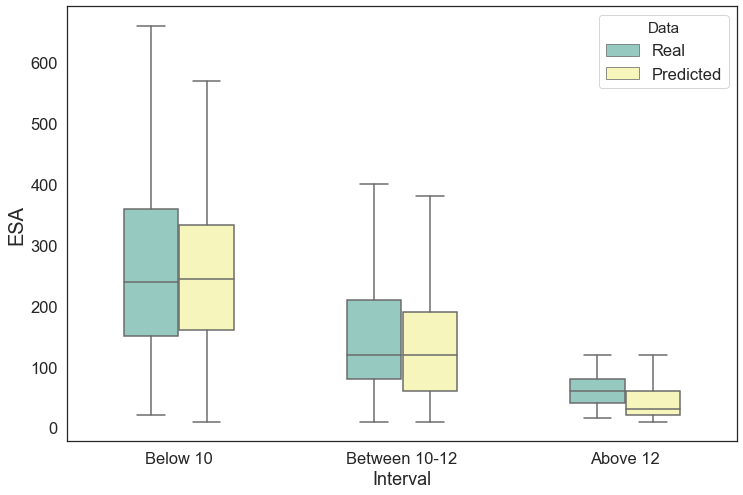

Below 10
All Instances: 264
Instances (EPO > 0) - Real: 217
ESA (Mean/Std) - Real: 261.9 / 153.1
ESA (IQR)- Real: [150. 240. 360.]
Instances (EPO > 0) - AI: 212
ESA (Mean/Std) - AI: 257.3 / 127.2
ESA (IQR)- AI: [160.  245.  332.5]
T-test p-value (Real vs AI): 0.7359176202108215
--------------------
Between 10-12
All Instances: 779
Instances (EPO > 0) - Real: 551
ESA (Mean/Std) - Real: 160.4 / 117.5
ESA (IQR)- Real: [ 80. 120. 210.]
Instances (EPO > 0) - AI: 574
ESA (Mean/Std) - AI: 140.1 / 99.5
ESA (IQR)- AI: [ 60. 120. 190.]
T-test p-value (Real vs AI): 0.0017704725036291093
--------------------
Above 12
All Instances: 145
Instances (EPO > 0) - Real: 44
ESA (Mean/Std) - Real: 72.5 / 58.2
ESA (IQR)- Real: [40. 60. 80.]
Instances (EPO > 0) - AI: 61
ESA (Mean/Std) - AI: 43.1 / 32.9
ESA (IQR)- AI: [20. 30. 60.]
T-test p-value (Real vs AI): 0.0015610847748701898


In [48]:
non_zero_real_epo_valid = [np.nan if e==0 else e for e in real_epo_valid]
non_zero_ai_epo_valid = [np.nan if e==0 else e for e in ai_epo_valid] 
non_zero_real_epo_non_na_valid = [e for e in non_zero_real_epo_valid if not np.isnan(e)]
non_zero_ai_epo_non_na_valid = [e for e in non_zero_ai_epo_valid if not np.isnan(e)] 
esa_by_interval_valid = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_valid+ESA_sensitivity_interval_t0_valid, 
                                      'ESA': non_zero_real_epo_valid+non_zero_ai_epo_valid,
                                      'Data': ['Real']*len(real_epo_valid) + ['Predicted']*len(ai_epo_valid),
                                      'MAE': np.abs(epo_diff_valid + epo_diff_valid)
                                               })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="ESA", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=esa_by_interval_valid, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('ESA', fontsize=20)
plt.savefig('ESA_BoxPlot_Interval - Train',dpi=1000)
plt.show()
# print('ESA - Real:', np.mean(non_zero_real_epo_non_na_valid), np.std(non_zero_real_epo_non_na_valid))
# print('ESA - AI:', np.mean(non_zero_ai_epo_non_na_valid), np.std(non_zero_ai_epo_non_na_valid))
# print('T-test p-value:', stats.ttest_ind(non_zero_real_epo_non_na_valid, non_zero_ai_epo_non_na_valid).pvalue)
# print('Below 10')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_valid if i =='Below 10']))
# non_zero_real_epo_non_na_below10_valid = [e for i, e in zip(ESA_sensitivity_interval_t0_valid, non_zero_real_epo_valid) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_below10_valid))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_below10_valid).round(1), '/', np.std(non_zero_real_epo_non_na_below10_valid).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_below10_valid, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_below10_valid = [e for i, e in zip(ESA_sensitivity_interval_t0_valid, non_zero_ai_epo_valid) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_below10_valid))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_below10_valid).round(1), '/', np.std(non_zero_ai_epo_non_na_below10_valid).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_below10_valid, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_below10_valid, non_zero_ai_epo_non_na_below10_valid).pvalue)
# print('--------------------')
# print('Between 10-12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_valid if i =='Between 10-12']))
# non_zero_real_epo_non_na_btw1012_valid = [e for i, e in zip(ESA_sensitivity_interval_t0_valid, non_zero_real_epo_valid) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_btw1012_valid))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_btw1012_valid).round(1), '/', np.std(non_zero_real_epo_non_na_btw1012_valid).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_btw1012_valid, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_btw1012_valid = [e for i, e in zip(ESA_sensitivity_interval_t0_valid, non_zero_ai_epo_valid) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_btw1012_valid))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_btw1012_valid).round(1), '/', np.std(non_zero_ai_epo_non_na_btw1012_valid).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_btw1012_valid, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_btw1012_valid, non_zero_ai_epo_non_na_btw1012_valid).pvalue)
# print('--------------------')
# print('Above 12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_valid if i =='Above 12']))
# non_zero_real_epo_non_na_above12_valid = [e for i, e in zip(ESA_sensitivity_interval_t0_valid, non_zero_real_epo_valid) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_above12_valid))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_above12_valid).round(1), '/', np.std(non_zero_real_epo_non_na_above12_valid).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_above12_valid, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_above12_valid = [e for i, e in zip(ESA_sensitivity_interval_t0_valid, non_zero_ai_epo_valid) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_above12_valid))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_above12_valid).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_valid).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_above12_valid, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_above12_valid, non_zero_ai_epo_non_na_above12_valid).pvalue)

In [35]:
# succ_fail_esa_by_interval_valid = pd.DataFrame({
#                                               'ESA': success_real_epo_valid+failure_real_epo_valid+success_ai_epo_valid+success_ai_epo_valid,
#                                               'Succ/Fail': ['Success(Real)']*len(success_real_epo_valid) + ['Failure(Real)']*len(failure_real_epo_valid) +
#                                                            ['Success(Real)']*len(success_ai_epo_valid) + ['Failure(Real)']*len(success_ai_epo_valid),
#                                               'Data': ['Real']*len(success_real_epo_valid) + ['Real']*len(failure_real_epo_valid) +
#                                                       ['AI']*len(success_ai_epo_valid) + ['AI']*len(success_ai_epo_valid),
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Succ/Fail", y="ESA", hue="Data", order=['Success(Real)','Failure(Real)'],
#             data=succ_fail_esa_by_interval_valid, palette="Set3", width=0.5, showfliers=False)
# plt.ylabel('ESA', fontsize=20)
# plt.ylim(0,800)
# plt.savefig('ESA_BoxPlot_Success_Failure - Valid',dpi=1000)
# plt.show()
# print('ESA (Success - Real) Instances:', len(success_real_epo_valid))
# print('ESA (Success - Real) Mean/Std:', np.mean(len(success_real_epo_valid)).round(1), '/', np.std(success_real_epo_valid).round(1))
# print('ESA (Success - Real) IQR:',  np.percentile(success_real_epo_valid, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_valid))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_valid).round(1),'/',  np.std(success_ai_epo_valid).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_valid, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Succ-Real vs Succ-AI ):', stats.ttest_ind(success_real_epo_valid, success_ai_epo_valid).pvalue)
# print('--------------------')
# print('ESA (Failure - Real) Instances:', len(failure_real_epo_valid))
# print('ESA (Failure - Real) Mean/Std:', np.mean(failure_real_epo_valid).round(1), '/', np.std(failure_real_epo_valid).round(1))
# print('ESA (Failure - Real) IQR:',  np.percentile(failure_real_epo_valid, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_valid))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_valid).round(1),'/',  np.std(success_ai_epo_valid).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_valid, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Real-Fail vs Succ-AI ):', stats.ttest_ind(failure_real_epo_valid, success_ai_epo_valid).pvalue)



# esa_mse_by_interval_t0_valid = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_valid+ESA_sensitivity_interval_t0_valid, 
#                                           'MAE': np.abs(epo_diff_valid + epo_diff_valid)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t0_valid, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t0_valid.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t0_Interval - Valid',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t0_valid))
# print(len(ESA_sensitivity_interval_t0_valid))



# esa_mse_by_interval_t1_valid = pd.DataFrame({'Interval': ESA_sensitivity_interval_t1_valid+ESA_sensitivity_interval_t1_valid, 
#                                           'MAE': np.abs(epo_diff_valid + epo_diff_valid)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t1_valid, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t1_valid.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t1_Interval - Valid',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t1_valid))
# print(len(ESA_sensitivity_interval_t1_valid))

## Test

In [36]:
epo_diff_test = []
real_epo_test = []
ai_epo_test = []

below10_t1_test = []
betw1012_t1_test = []
above12_t1_test = []

below10_t0_test = []
betw1012_t0_test = []
above12_t0_test = []

ESA_sensitivity_interval_t0_test = []
ESA_sensitivity_interval_t1_test = []

success_real_epo_test = []
success_ai_epo_test = []
failure_real_epo_test = []

for p in tqdm(test_patient):
    
    x = temp[temp['Study_Subject_Number']==p]
    y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values
    if len(x)>seq_len:
        order = x['Order'].values       
        x = trn_scaler_mean.transform(x[trn_vars])
        for i in range(seq_len, len(x)+1):
            
            x_ = x[i-seq_len:i] # normalized
            
            prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
            prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
            prev_epo = np.abs(prev_epo)

            cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
            cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
            cur_epo = np.abs(cur_epo)
            next_hb = y[i-1] # 10

            target_y = np.array([next_hb]) # 10
            target_y_normalized = transform_target_hb(target_y) # normalized

            past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
            epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9

            epo_pred = ans_process(epo_pred)[0] # 400
            epo_pred_normalized = transform_epo(epo_pred)
            
            x_temp = x_.copy()
            x_temp[-1,epo_idx] = epo_pred_normalized
            
            hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp]))).round(1)
            
            epo_diff_test.append(cur_epo - epo_pred)
            real_epo_test.append(cur_epo)
            ai_epo_test.append(epo_pred)
            if next_hb < 10:
                below10_t1_test.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_test.append('Below 10')
            elif next_hb >= 10 and next_hb <= 12:
                betw1012_t1_test.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_test.append('Between 10-12')
            else:
                above12_t1_test.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t1_test.append('Above 12')
                
            if cur_hb < 10:
                below10_t0_test.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_test.append('Below 10')
            elif cur_hb >= 10 and cur_hb <= 12:
                betw1012_t0_test.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_test.append('Between 10-12')
            else:
                above12_t0_test.append(cur_epo - epo_pred)
                ESA_sensitivity_interval_t0_test.append('Above 12')
                
            if cur_hb < 10 and next_hb >= 10:
                success_real_epo_test.append(cur_epo)
            elif cur_hb < 10 and next_hb < 10:
                failure_real_epo_test.append(cur_epo)                         
            if cur_hb < 10 and hb_AI[0][0] >= 10:
                success_ai_epo_test.append(epo_pred)

100%|██████████████████████████████████| 47/47 [00:14<00:00,  3.17it/s]


In [37]:
print('All:', len(epo_diff_test), '| Acc: ', np.mean(np.abs(epo_diff_test)).round(4)) 

print('---------------')
print('Invervals by Hb(t+1),')
below10_esa_error_t1_test = np.mean(np.abs(below10_t1_test)).round(4)
print('Below 10:', len(below10_t1_test), 
      '| Higher than MAE('+str(below10_esa_error_t1_test)+'):', 
      len([e for e in np.abs(below10_t1_test) if e > below10_esa_error_t1_test]),
      '| Lower than MAE('+str(below10_esa_error_t1_test)+'):',
      len([e for e in np.abs(below10_t1_test) if e <= below10_esa_error_t1_test])
     ) 
betw1012_esa_error_t1_test = np.mean(np.abs(betw1012_t1_test)).round(4)
print('10 - 12:', len(betw1012_t1_test), 
      '| Higher than MAE('+str(betw1012_esa_error_t1_test)+'):', 
      len([e for e in np.abs(betw1012_t1_test) if e > betw1012_esa_error_t1_test]),
      '| Lower than MAE('+str(betw1012_esa_error_t1_test)+'):',
      len([e for e in np.abs(betw1012_t1_test) if e <= betw1012_esa_error_t1_test])
     ) 
above12_esa_error_t1_test = np.mean(np.abs(above12_t1_test)).round(4)
print('Above 12:', len(above12_t1_test), 
      '| Higher than MAE('+str(above12_esa_error_t1_test)+'):', 
      len([e for e in np.abs(above12_t1_test) if e > above12_esa_error_t1_test]),
      '| Lower than MAE('+str(above12_esa_error_t1_test)+'):',
      len([e for e in np.abs(above12_t1_test) if e <= above12_esa_error_t1_test])
     )

print('---------------')
print('Invervals by Hb(t),')
below10_esa_error_t0_test = np.mean(np.abs(below10_t0_test)).round(4)
print('Below 10:', len(below10_t0_test), 
      '| Higher than MAE('+str(below10_esa_error_t0_test)+'):', 
      len([e for e in np.abs(below10_t0_test) if e > below10_esa_error_t0_test]),
      '| Lower than MAE('+str(below10_esa_error_t0_test)+'):',
      len([e for e in np.abs(below10_t0_test) if e <= below10_esa_error_t0_test])
     ) 
betw1012_esa_error_t0_test = np.mean(np.abs(betw1012_t0_test)).round(4)
print('10 - 12:', len(betw1012_t0_test), 
      '| Higher than MAE('+str(betw1012_esa_error_t0_test)+'):', 
      len([e for e in np.abs(betw1012_t0_test) if e > betw1012_esa_error_t0_test]),
      '| Lower than MAE('+str(betw1012_esa_error_t0_test)+'):',
      len([e for e in np.abs(betw1012_t0_test) if e <= betw1012_esa_error_t0_test])
     ) 
above12_esa_error_t0_test = np.mean(np.abs(above12_t0_test)).round(4)
print('Above 12:', len(above12_t0_test), 
      '| Higher than MAE('+str(above12_esa_error_t0_test)+'):', 
      len([e for e in np.abs(above12_t0_test) if e > above12_esa_error_t0_test]),
      '| Lower than MAE('+str(above12_esa_error_t0_test)+'):',
      len([e for e in np.abs(above12_t0_test) if e <= above12_esa_error_t0_test])
     )

All: 1395 | Acc:  43.205
---------------
Invervals by Hb(t+1),
Below 10: 283 | Higher than MAE(47.2438): 101 | Lower than MAE(47.2438): 182
10 - 12: 963 | Higher than MAE(41.2056): 316 | Lower than MAE(41.2056): 647
Above 12: 149 | Higher than MAE(48.4564): 61 | Lower than MAE(48.4564): 88
---------------
Invervals by Hb(t),
Below 10: 278 | Higher than MAE(62.3813): 98 | Lower than MAE(62.3813): 180
10 - 12: 970 | Higher than MAE(41.0866): 336 | Lower than MAE(41.0866): 634
Above 12: 147 | Higher than MAE(20.9184): 32 | Lower than MAE(20.9184): 115


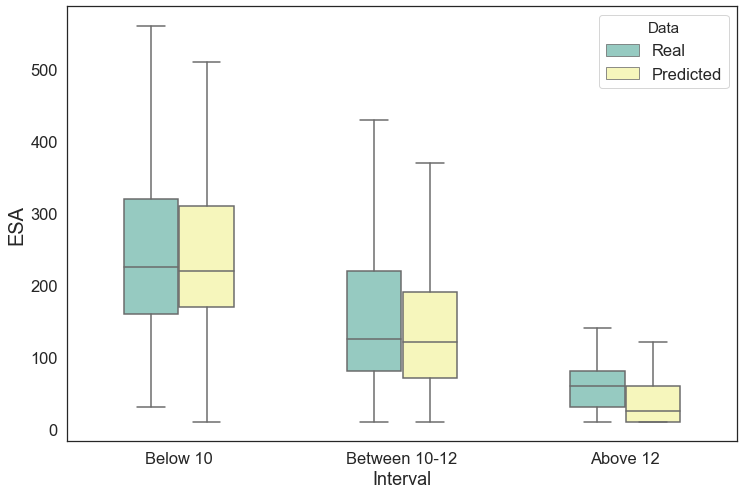

Below 10
All Instances: 278
Instances (EPO > 0) - Real: 222
ESA (Mean/Std) - Real: 254.9 / 133.5
ESA (IQR)- Real: [160. 225. 320.]
Instances (EPO > 0) - AI: 219
ESA (Mean/Std) - AI: 249.0 / 128.0
ESA (IQR)- AI: [170. 220. 310.]
T-test p-value (Real vs AI): 0.6353860017295359
--------------------
Between 10-12
All Instances: 970
Instances (EPO > 0) - Real: 695
ESA (Mean/Std) - Real: 165.7 / 123.9
ESA (IQR)- Real: [ 80. 125. 220.]
Instances (EPO > 0) - AI: 731
ESA (Mean/Std) - AI: 145.9 / 107.6
ESA (IQR)- AI: [ 70. 120. 190.]
T-test p-value (Real vs AI): 0.0012597570746599237
--------------------
Above 12
All Instances: 147
Instances (EPO > 0) - Real: 67
ESA (Mean/Std) - Real: 70.5 / 79.9
ESA (IQR)- Real: [30. 60. 80.]
Instances (EPO > 0) - AI: 76
ESA (Mean/Std) - AI: 40.5 / 35.7
ESA (IQR)- AI: [10. 25. 60.]
T-test p-value (Real vs AI): 0.003887582273318807


In [49]:
non_zero_real_epo_test = [np.nan if e==0 else e for e in real_epo_test]
non_zero_ai_epo_test = [np.nan if e==0 else e for e in ai_epo_test] 
non_zero_real_epo_non_na_test = [e for e in non_zero_real_epo_test if not np.isnan(e)]
non_zero_ai_epo_non_na_test = [e for e in non_zero_ai_epo_test if not np.isnan(e)] 
esa_by_interval_test = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_test+ESA_sensitivity_interval_t0_test, 
                                      'ESA': non_zero_real_epo_test+non_zero_ai_epo_test,
                                      'Data': ['Real']*len(real_epo_test) + ['Predicted']*len(ai_epo_test),
                                      'MAE': np.abs(epo_diff_test + epo_diff_test)
                                               })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="ESA", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=esa_by_interval_test, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('ESA', fontsize=20)
plt.savefig('ESA_BoxPlot_Interval - Train',dpi=1000)
plt.show()
# print('ESA - Real:', np.mean(non_zero_real_epo_non_na_test), np.std(non_zero_real_epo_non_na_test))
# print('ESA - AI:', np.mean(non_zero_ai_epo_non_na_test), np.std(non_zero_ai_epo_non_na_test))
# print('T-test p-value:', stats.ttest_ind(non_zero_real_epo_non_na_test, non_zero_ai_epo_non_na_test).pvalue)
# print('Below 10')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_test if i =='Below 10']))
# non_zero_real_epo_non_na_below10_test = [e for i, e in zip(ESA_sensitivity_interval_t0_test, non_zero_real_epo_test) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_below10_test))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_below10_test).round(1), '/', np.std(non_zero_real_epo_non_na_below10_test).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_below10_test, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_below10_test = [e for i, e in zip(ESA_sensitivity_interval_t0_test, non_zero_ai_epo_test) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_below10_test))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_below10_test).round(1), '/', np.std(non_zero_ai_epo_non_na_below10_test).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_below10_test, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_below10_test, non_zero_ai_epo_non_na_below10_test).pvalue)
# print('--------------------')
# print('Between 10-12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_test if i =='Between 10-12']))
# non_zero_real_epo_non_na_btw1012_test = [e for i, e in zip(ESA_sensitivity_interval_t0_test, non_zero_real_epo_test) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_btw1012_test))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_btw1012_test).round(1), '/', np.std(non_zero_real_epo_non_na_btw1012_test).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_btw1012_test, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_btw1012_test = [e for i, e in zip(ESA_sensitivity_interval_t0_test, non_zero_ai_epo_test) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_btw1012_test))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_btw1012_test).round(1), '/', np.std(non_zero_ai_epo_non_na_btw1012_test).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_btw1012_test, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_btw1012_test, non_zero_ai_epo_non_na_btw1012_test).pvalue)
# print('--------------------')
# print('Above 12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_test if i =='Above 12']))
# non_zero_real_epo_non_na_above12_test = [e for i, e in zip(ESA_sensitivity_interval_t0_test, non_zero_real_epo_test) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_above12_test))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_above12_test).round(1), '/', np.std(non_zero_real_epo_non_na_above12_test).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_above12_test, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_above12_test = [e for i, e in zip(ESA_sensitivity_interval_t0_test, non_zero_ai_epo_test) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_above12_test))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_above12_test).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_test).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_above12_test, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_above12_test, non_zero_ai_epo_non_na_above12_test).pvalue)

In [39]:
# succ_fail_esa_by_interval_test = pd.DataFrame({
#                                               'ESA': success_real_epo_test+failure_real_epo_test+success_ai_epo_test+success_ai_epo_test,
#                                               'Succ/Fail': ['Success(Real)']*len(success_real_epo_test) + ['Failure(Real)']*len(failure_real_epo_test) +
#                                                            ['Success(Real)']*len(success_ai_epo_test) + ['Failure(Real)']*len(success_ai_epo_test),
#                                               'Data': ['Real']*len(success_real_epo_test) + ['Real']*len(failure_real_epo_test) +
#                                                       ['AI']*len(success_ai_epo_test) + ['AI']*len(success_ai_epo_test),
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Succ/Fail", y="ESA", hue="Data", order=['Success(Real)','Failure(Real)'],
#             data=succ_fail_esa_by_interval_test, palette="Set3", width=0.5, showfliers=False)
# plt.ylabel('ESA', fontsize=20)
# plt.ylim(0,800)
# plt.savefig('ESA_BoxPlot_Success_Failure - Test',dpi=1000)
# plt.show()
# print('ESA (Success - Real) Instances:', len(success_real_epo_test))
# print('ESA (Success - Real) Mean/Std:', np.mean(len(success_real_epo_test)).round(1), '/', np.std(success_real_epo_test).round(1))
# print('ESA (Success - Real) IQR:',  np.percentile(success_real_epo_test, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_test))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_test).round(1),'/',  np.std(success_ai_epo_test).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_test, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Succ-Real vs Succ-AI ):', stats.ttest_ind(success_real_epo_test, success_ai_epo_test).pvalue)
# print('--------------------')
# print('ESA (Failure - Real) Instances:', len(failure_real_epo_test))
# print('ESA (Failure - Real) Mean/Std:', np.mean(failure_real_epo_test).round(1), '/', np.std(failure_real_epo_test).round(1))
# print('ESA (Failure - Real) IQR:',  np.percentile(failure_real_epo_test, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_test))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_test).round(1),'/',  np.std(success_ai_epo_test).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_test, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Real-Fail vs Succ-AI ):', stats.ttest_ind(failure_real_epo_test, success_ai_epo_test).pvalue)




# esa_mse_by_interval_t0_test = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_test+ESA_sensitivity_interval_t0_test, 
#                                           'MAE': np.abs(epo_diff_test + epo_diff_test)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t0_test, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t0_test.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t0_Interval - Test',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t0_test))
# print(len(ESA_sensitivity_interval_t0_test))



# esa_mse_by_interval_t1_test = pd.DataFrame({'Interval': ESA_sensitivity_interval_t1_test+ESA_sensitivity_interval_t1_test, 
#                                           'MAE': np.abs(epo_diff_test + epo_diff_test)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t1_test, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t1_test.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t1_Interval - Test',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t1_test))
# print(len(ESA_sensitivity_interval_t1_test))

## All

In [40]:
epo_diff_all = epo_diff_train + epo_diff_valid + epo_diff_test
real_epo_all = real_epo_train + real_epo_valid + real_epo_test
ai_epo_all = ai_epo_train + ai_epo_valid + ai_epo_test

below10_t1_all = below10_t1_train + below10_t1_valid + below10_t1_test
betw1012_t1_all = betw1012_t1_train + betw1012_t1_valid + betw1012_t1_test
above12_t1_all = above12_t1_train + above12_t1_valid + above12_t1_test

below10_t0_all = below10_t0_train + below10_t0_valid + below10_t0_test
betw1012_t0_all = betw1012_t0_train + betw1012_t0_valid + betw1012_t0_test
above12_t0_all = above12_t0_train + above12_t0_valid + above12_t0_test

ESA_sensitivity_interval_t0_all = ESA_sensitivity_interval_t0_train + ESA_sensitivity_interval_t0_valid + ESA_sensitivity_interval_t0_test
ESA_sensitivity_interval_t1_all = ESA_sensitivity_interval_t1_train + ESA_sensitivity_interval_t1_valid + ESA_sensitivity_interval_t1_test

success_real_epo_all = success_real_epo_train + success_real_epo_valid + success_real_epo_test
success_ai_epo_all = success_ai_epo_train + success_ai_epo_valid + success_ai_epo_test
failure_real_epo_all = failure_real_epo_train + failure_real_epo_valid + failure_real_epo_test

non_zero_real_epo_all = non_zero_real_epo_train + non_zero_real_epo_valid + non_zero_real_epo_test
non_zero_ai_epo_all = non_zero_ai_epo_train + non_zero_ai_epo_valid + non_zero_ai_epo_test
non_zero_real_epo_non_na_all = non_zero_real_epo_non_na_train + non_zero_real_epo_non_na_valid + non_zero_real_epo_non_na_test
non_zero_ai_epo_non_na_all = non_zero_ai_epo_non_na_train + non_zero_ai_epo_non_na_valid + non_zero_ai_epo_non_na_test

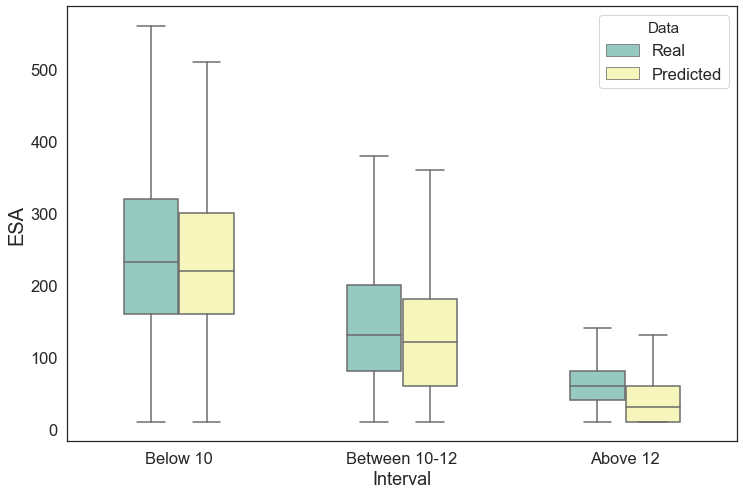

Below 10
All Instances: 2723
Instances (EPO > 0) - Real: 2196
ESA (Mean/Std) - Real: 252.6 / 131.5
ESA (IQR)- Real: [160.  232.5 320. ]
Instances (EPO > 0) - AI: 2220
ESA (Mean/Std) - AI: 238.7 / 115.0
ESA (IQR)- AI: [160. 220. 300.]
T-test p-value (Real vs AI): 0.00018547416986242272
--------------------
Between 10-12
All Instances: 8609
Instances (EPO > 0) - Real: 5828
ESA (Mean/Std) - Real: 157.1 / 112.9
ESA (IQR)- Real: [ 80. 130. 200.]
Instances (EPO > 0) - AI: 6361
ESA (Mean/Std) - AI: 132.6 / 98.6
ESA (IQR)- AI: [ 60. 120. 180.]
T-test p-value (Real vs AI): 3.2022062772618718e-37
--------------------
Above 12
All Instances: 1565
Instances (EPO > 0) - Real: 503
ESA (Mean/Std) - Real: 68.7 / 53.8
ESA (IQR)- Real: [40. 60. 80.]
Instances (EPO > 0) - AI: 585
ESA (Mean/Std) - AI: 41.0 / 34.3
ESA (IQR)- AI: [10. 30. 60.]
T-test p-value (Real vs AI): 1.6201596653004383e-23


In [50]:
non_zero_real_epo_all = [np.nan if e==0 else e for e in real_epo_all]
non_zero_ai_epo_all = [np.nan if e==0 else e for e in ai_epo_all] 
non_zero_real_epo_non_na_all = [e for e in non_zero_real_epo_all if not np.isnan(e)]
non_zero_ai_epo_non_na_all = [e for e in non_zero_ai_epo_all if not np.isnan(e)] 
esa_by_interval_all = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_all+ESA_sensitivity_interval_t0_all, 
                                      'ESA': non_zero_real_epo_all+non_zero_ai_epo_all,
                                      'Data': ['Real']*len(real_epo_all) + ['Predicted']*len(ai_epo_all),
                                      'MAE': np.abs(epo_diff_all + epo_diff_all)
                                               })
plt.rcParams["figure.figsize"] = (12,8)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(x="Interval", y="ESA", hue="Data", order=['Below 10','Between 10-12','Above 12'],
            data=esa_by_interval_all, palette="Set3", width=0.5, showfliers=False)
plt.ylabel('ESA', fontsize=20)
plt.savefig('ESA_BoxPlot_Interval - Train',dpi=1000)
plt.show()
# print('ESA - Real:', np.mean(non_zero_real_epo_non_na_all), np.std(non_zero_real_epo_non_na_all))
# print('ESA - AI:', np.mean(non_zero_ai_epo_non_na_all), np.std(non_zero_ai_epo_non_na_all))
# print('T-test p-value:', stats.ttest_ind(non_zero_real_epo_non_na_all, non_zero_ai_epo_non_na_all).pvalue)
# print('Below 10')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_all if i =='Below 10']))
# non_zero_real_epo_non_na_below10_all = [e for i, e in zip(ESA_sensitivity_interval_t0_all, non_zero_real_epo_all) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_below10_all))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_below10_all).round(1), '/', np.std(non_zero_real_epo_non_na_below10_all).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_below10_all, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_below10_all = [e for i, e in zip(ESA_sensitivity_interval_t0_all, non_zero_ai_epo_all) if i =='Below 10' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_below10_all))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_below10_all).round(1), '/', np.std(non_zero_ai_epo_non_na_below10_all).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_below10_all, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_below10_all, non_zero_ai_epo_non_na_below10_all).pvalue)
# print('--------------------')
# print('Between 10-12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_all if i =='Between 10-12']))
# non_zero_real_epo_non_na_btw1012_all = [e for i, e in zip(ESA_sensitivity_interval_t0_all, non_zero_real_epo_all) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_btw1012_all))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_btw1012_all).round(1), '/', np.std(non_zero_real_epo_non_na_btw1012_all).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_btw1012_all, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_btw1012_all = [e for i, e in zip(ESA_sensitivity_interval_t0_all, non_zero_ai_epo_all) if i =='Between 10-12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_btw1012_all))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_btw1012_all).round(1), '/', np.std(non_zero_ai_epo_non_na_btw1012_all).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_btw1012_all, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_btw1012_all, non_zero_ai_epo_non_na_btw1012_all).pvalue)
# print('--------------------')
# print('Above 12')
# print('All Instances:', len([i for i in ESA_sensitivity_interval_t0_all if i =='Above 12']))
# non_zero_real_epo_non_na_above12_all = [e for i, e in zip(ESA_sensitivity_interval_t0_all, non_zero_real_epo_all) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - Real:', len(non_zero_real_epo_non_na_above12_all))
# print('ESA (Mean/Std) - Real:', np.mean(non_zero_real_epo_non_na_above12_all).round(1), '/', np.std(non_zero_real_epo_non_na_above12_all).round(1))
# print('ESA (IQR)- Real:',  np.percentile(non_zero_real_epo_non_na_above12_all, q=[25, 50, 75]).round(1))
# non_zero_ai_epo_non_na_above12_all = [e for i, e in zip(ESA_sensitivity_interval_t0_all, non_zero_ai_epo_all) if i =='Above 12' and not np.isnan(e)]
# print('Instances (EPO > 0) - AI:', len(non_zero_ai_epo_non_na_above12_all))
# print('ESA (Mean/Std) - AI:', np.mean(non_zero_ai_epo_non_na_above12_all).round(1), '/', np.std(non_zero_ai_epo_non_na_above12_all).round(1))
# print('ESA (IQR)- AI:',  np.percentile(non_zero_ai_epo_non_na_above12_all, q=[25, 50, 75]).round(1))
# print('T-test p-value (Real vs AI):', stats.ttest_ind(non_zero_real_epo_non_na_above12_all, non_zero_ai_epo_non_na_above12_all).pvalue)

In [29]:
# succ_fail_esa_by_interval_all = pd.DataFrame({
#                                               'ESA': success_real_epo_all+failure_real_epo_all+success_ai_epo_all+success_ai_epo_all,
#                                               'Succ/Fail': ['Success(Real)']*len(success_real_epo_all) + ['Failure(Real)']*len(failure_real_epo_all) +
#                                                            ['Success(Real)']*len(success_ai_epo_all) + ['Failure(Real)']*len(success_ai_epo_all),
#                                               'Data': ['Real']*len(success_real_epo_all) + ['Real']*len(failure_real_epo_all) +
#                                                       ['AI']*len(success_ai_epo_all) + ['AI']*len(success_ai_epo_all),
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Succ/Fail", y="ESA", hue="Data", order=['Success(Real)','Failure(Real)'],
#             data=succ_fail_esa_by_interval_all, palette="Set3", width=0.5, showfliers=False)
# plt.ylabel('ESA', fontsize=20)
# plt.ylim(0,800)
# plt.savefig('ESA_BoxPlot_Success_Failure - All',dpi=1000)
# plt.show()
# print('ESA (Success - Real) Instances:', len(success_real_epo_all))
# print('ESA (Success - Real) Mean/Std:', np.mean(len(success_real_epo_all)).round(1), '/', np.std(success_real_epo_all).round(1))
# print('ESA (Success - Real) IQR:',  np.percentile(success_real_epo_all, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_all))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_all).round(1),'/',  np.std(success_ai_epo_all).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_all, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Succ-Real vs Succ-AI ):', stats.ttest_ind(success_real_epo_all, success_ai_epo_all).pvalue)
# print('--------------------')
# print('ESA (Failure - Real) Instances:', len(failure_real_epo_all))
# print('ESA (Failure - Real) Mean/Std:', np.mean(failure_real_epo_all).round(1), '/', np.std(failure_real_epo_all).round(1))
# print('ESA (Failure - Real) IQR:',  np.percentile(failure_real_epo_all, q=[25, 50, 75]).round(1))
# print('ESA (Success - AI) Instances:', len(success_ai_epo_all))
# print('ESA (Success - AI) Mean/Std:', np.mean(success_ai_epo_all).round(1),'/',  np.std(success_ai_epo_all).round(1))
# print('ESA (Success - AI) IQR:',  np.percentile(success_ai_epo_all, q=[25, 50, 75]).round(1))
# print('T-test p-value ( Real-Fail vs Succ-AI ):', stats.ttest_ind(failure_real_epo_all, success_ai_epo_all).pvalue)




# esa_mse_by_interval_t0_all = pd.DataFrame({'Interval': ESA_sensitivity_interval_t0_all+ESA_sensitivity_interval_t0_all, 
#                                           'MAE': np.abs(epo_diff_all + epo_diff_all)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t0_all, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t0_all.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t0_Interval - All',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t0_all))
# print(len(ESA_sensitivity_interval_t0_all))



# esa_mse_by_interval_t1_all = pd.DataFrame({'Interval': ESA_sensitivity_interval_t1_all+ESA_sensitivity_interval_t1_all, 
#                                           'MAE': np.abs(epo_diff_all + epo_diff_all)
#                                                })
# plt.rcParams["figure.figsize"] = (12,8)
# sns.set(font_scale=1.5)
# sns.set_style("white")
# sns.boxplot(x="Interval", y="MAE", order=['Below 10','Between 10-12','Above 12'],
#             data=esa_mse_by_interval_t1_all, palette="Set3", width=0.5, showfliers=False)
# sns.pointplot(x='Interval', y='MAE', data=esa_mse_by_interval_t1_all.groupby('Interval', as_index=False).mean(), order=['Below 10','Between 10-12','Above 12'],
#               point_kws = {'label':'MAE'}, color='r')
# plt.ylabel('ESA', fontsize=20)
# plt.savefig('ESA_MAE_BoxPlot_t1_Interval - All',dpi=1000)
# plt.show()
# print(Counter(ESA_sensitivity_interval_t1_all))
# print(len(ESA_sensitivity_interval_t1_all))

# Recommendation Plot

In [ ]:
# plt.rcParams["figure.figsize"] = (8,5)
# regulated_hb_error = []
# epo_error = []
# hb_pred_pred = []
# hb_error = []
# for p in tqdm(test_patient[10:20]):
    
#     x = temp[temp['Study_Subject_Number']==p]
#     y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values    
#     if len(x)>seq_len:        
#         x = trn_scaler_mean.transform(x[trn_vars])
#         orders = temp['Order'][temp['Study_Subject_Number']==p].values
#         for i in range(seq_len, len(x)+1):
            
#             x_ = x[i-seq_len:i] # normalized
#             data_order = orders[i-seq_len:i]
            
#             prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
#             prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
#             prev_hb_record = inverse_transform_hb(x[:i-1,hb_idx]) # 10
#             prev_epo_record = inverse_transform_epo(x[:i-1,epo_idx]) # 400            
#             prev_epo = np.abs(prev_epo)

#             cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
#             cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
#             cur_epo = np.abs(cur_epo)
#             next_hb = y[i-1] # 10

#             # Pred Hb -><- Real Hb
#             x_temp = x_.copy()
#             hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp])))            
            
#             x_lims = 10
#             cur_hb_table = np.concatenate([prev_hb_record, [cur_hb], [np.nan]])[-x_lims:]
#             cur_epo_table = np.concatenate([prev_epo_record, [cur_epo], [np.nan]])[-x_lims:]
#             next_hb_table = np.concatenate([[np.nan]*(i), [next_hb]])[-x_lims:]
#             hb_AI_table = np.concatenate([[np.nan]*(i), hb_AI[0]]).round(1)[-x_lims:]

#             m1_t = pd.DataFrame({
#                  'cur_hb' : cur_hb_table,
#                  'cur_epo' : cur_epo_table,
#                  'next_hb' : next_hb_table,
#                  'hb_AI': hb_AI_table
#             })

#             # EPO Recommended by Doctors    
#             width = 0.25
#             m1_t['cur_epo'].plot(kind='bar', width = width, fc=(1, 0, 0, 0.1))
#             for i, t in enumerate(cur_epo_table):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, 100, "%4.1f" % (t), color ='r')
#             plt.ylim(0, 1000)
#             m1_t['cur_hb'].plot(secondary_y=True, style='*-', c='k')
#             for i, t in enumerate(m1_t['cur_hb'].values):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, t+0.5, "%2.1f" % (t), color ='k')            
#             plt.ylim(4, 18)            
            
#             if hb_AI <= next_hb:
#                 m1_t['next_hb'].plot(secondary_y=True, style='*', c='k')   
#                 for i, t in enumerate(m1_t['next_hb'].values):
#                     if not np.isnan(t):
#                         plt.text(i-0.33, t+0.5, "%2.1f" % (t), color ='k')

#                 m1_t['hb_AI'].plot(secondary_y=True, style='*', c='b')
#                 for i, t in enumerate(m1_t['hb_AI'].values):
#                     if not np.isnan(t):
#                         plt.text(i-0.33, t-1, "%2.1f" % (t), color ='b')
#             else:
#                 m1_t['next_hb'].plot(secondary_y=True, style='*', c='k')   
#                 for i, t in enumerate(m1_t['next_hb'].values):
#                     if not np.isnan(t):
#                         plt.text(i-0.33, t-1, "%2.1f" % (t), color ='k')

#                 m1_t['hb_AI'].plot(secondary_y=True, style='*', c='b')
#                 for i, t in enumerate(m1_t['hb_AI'].values):
#                     if not np.isnan(t):
#                         plt.text(i-0.33, t+0.5, "%2.1f" % (t), color ='b')
                
#             plt.xlim(-1, x_lims+1)        
#             plt.show()

#             print(data_order)
#             print('************************************************************************')
#             print()
#             print()

In [62]:
# plt.rcParams["figure.figsize"] = (8,5)
# regulated_hb_error = []
# epo_error = []
# hb_pred_pred = []
# hb_error = []
# for p in tqdm(test_patient[:2]):
    
#     x = temp[temp['Study_Subject_Number']==p]
#     y = temp['Target_Hb'][temp['Study_Subject_Number']==p].values    
#     if len(x)>seq_len:        
#         x = trn_scaler_mean.transform(x[trn_vars])
#         orders = temp['Order'][temp['Study_Subject_Number']==p].values
#         for i in range(seq_len, len(x)+1):
            
#             x_ = x[i-seq_len:i] # normalized
#             data_order = orders[i-seq_len:i]
            
#             prev_hb = inverse_transform_hb(x[i-seq_len:i-1,hb_idx]) # 10
#             prev_epo = inverse_transform_epo(x[i-seq_len:i-1,epo_idx]) # 400
#             prev_hb_record = inverse_transform_hb(x[:i-1,hb_idx]) # 10
#             prev_epo_record = inverse_transform_epo(x[:i-1,epo_idx]) # 400            
#             prev_epo = np.abs(prev_epo)

#             cur_hb = inverse_transform_hb(x[i-1,hb_idx]) # 10
#             cur_epo = inverse_transform_epo(x[i-1,epo_idx]) # 400
#             cur_epo = np.abs(cur_epo)
#             next_hb = y[i-1] # 10

#             # Regulated Hb -> Pred EPO -> Pred Hb -><- Real Hb
#             target_y = np.array([targeting_hb(cur_hb)]) # 10
#             target_y_normalized = transform_target_hb(target_y) # normalized
#             past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
#             epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9
#             epo_pred = ans_process(epo_pred)[0] # 400
#             epo_pred_normalized = transform_epo(epo_pred)
#             x_temp = x_.copy()
#             x_temp[-1,epo_idx] = epo_pred_normalized
#             hb_AI = inverse_transform_target_hb(model.predict(np.array([x_temp])))
# #             regulated_hb_error.append(hb_AI[0][0] - next_hb)
             
# #             # Real Hb -> Pred EPO -><- Real EPO
# #             # Real Hb -> Pred EPO -> Pred Hb -><- Real Hb
# #             target_y = np.array([next_hb]) # 10
# #             target_y_normalized = transform_target_hb(target_y) # normalized
# #             past_info_, cur_info_wo_epo_, next_hb_, _ = recomm_dataset(np.array([x_]), target_y_normalized) # normalized, normalized, normalized, real
# #             epo_pred = remomm_model.predict([past_info_, cur_info_wo_epo_, next_hb_]) # 3.9
# #             epo_pred = ans_process(epo_pred)[0] # 400
# #             epo_pred_normalized = transform_epo(epo_pred)
# #             x_temp = x_.copy()
# #             x_temp[-1,epo_idx] = transform_epo(cur_epo)
# #             hb_AI_ = inverse_transform_target_hb(model.predict(np.array([x_temp])))
# #             epo_error.append(cur_epo - epo_pred)
# #             hb_pred_pred.append(next_hb - hb_AI_[0][0])

# #             # Pred Hb -><- Real Hb
# #             x_temp = x_.copy()
# #             hb_AI__ = inverse_transform_target_hb(model.predict(np.array([x_temp])))            
# #             hb_error.append(next_hb - hb_AI__)
                
#             x_lims = 10
#             cur_hb_table = np.concatenate([prev_hb_record, [cur_hb], [np.nan]])[-x_lims:]
#             cur_epo_table = np.concatenate([prev_epo_record, [cur_epo], [np.nan]])[-x_lims:]
#             cur_epo_prev_table = np.concatenate([prev_epo_record, [np.nan]*2])[-x_lims:]
#             target_y_table =  np.concatenate([[np.nan]*(i), target_y])[-x_lims:]
#             epo_pred_table = np.concatenate([[np.nan]*(i-1), [epo_pred], [np.nan]])[-x_lims:]
#             next_hb_table = np.concatenate([[np.nan]*(i), [next_hb]])[-x_lims:]
#             hb_AI_table = np.concatenate([[np.nan]*(i), hb_AI[0]]).round(1)[-x_lims:]

# #             print('cur_hb_:',cur_hb_table)
# #             print('cur_epo:',cur_epo_table)
# #             print('cur_epo_prev_table:',cur_epo_prev_table)
# #             print('target_y:',target_y_table)
# #             print('epo_pred:',epo_pred_table)
# #             print('next_hb:',next_hb_table)
# #             print('hb_AI:',hb_AI_table)

#             m1_t = pd.DataFrame({
#                  'cur_hb' : cur_hb_table,
#                  'cur_epo' : cur_epo_table,
#                  'cur_epo_prev':cur_epo_prev_table,

#                  'target_y' : target_y_table,
#                  'epo_pred': epo_pred_table,

#                  'next_hb' : next_hb_table,
#                  'hb_AI': hb_AI_table
#             })

#             # EPO Recommended by Doctors    
#             width = 0.25
#             m1_t['cur_epo'].plot(kind='bar', width = width, fc=(1, 0, 0, 0.1))
#             for i, t in enumerate(cur_epo_table):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, 100, "%4.1f" % (t), color ='r')
#             plt.ylabel('EPO')
#             plt.xlabel('Time')                     
#             plt.ylim(0, 1000)
#             m1_t['cur_hb'].plot(secondary_y=True, style='*-', c='k')
#             plt.ylim(4, 18)
#             m1_t['next_hb'].plot(secondary_y=True, style='*', c='k')   
#             plt.ylabel('Hb')                                
#             for i, t in enumerate(m1_t['cur_hb'].values):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, t+0.5, "%2.1f" % (t), color ='k')
#             for i, t in enumerate(m1_t['next_hb'].values):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, t+0.5, "%2.1f" % (t), color ='k')                    
#             plt.xlim(-1, x_lims+1)
#             plt.grid(linestyle='--')
# #             plt.axhline(y=10, color='g', linestyle='-')
# #             plt.axhline(y=12, color='g', linestyle='-')
#             plt.title('EPO Recommended by Doctors')         
#             plt.show()

#             # EPO Recommended by AI
#             m1_t['cur_epo_prev'].plot(kind='bar', width = width, fc=(1, 0, 0, 0.1))
#             m1_t['epo_pred'].plot(kind='bar', width = width, fc=(0, 0, 1, 0.1))
#             for i, t in enumerate(cur_epo_prev_table):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, 100, "%4.1f" % (t), color ='r')
#             plt.text(i-0.33-1, 100, "%4.1f" % (epo_pred), color = 'b')            
#             plt.ylabel('EPO')
#             plt.xlabel('Time') 
#             plt.title('EPO Recommended by AI')

#             plt.ylim(0, 1000)
#             m1_t['cur_hb'].plot(secondary_y=True, style='*-', c='k')
#             m1_t['target_y'].plot(secondary_y=True, style='*-', c='g')             
#             for i, t in enumerate(m1_t['cur_hb'].values):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, t+0.5, "%2.1f" % (t), color ='k')
#             plt.ylim(4, 18)
#             m1_t['hb_AI'].plot(secondary_y=True, style='*', c='b')
#             for i, t in enumerate(m1_t['hb_AI'].values):
#                 if not np.isnan(t):
#                     plt.text(i-0.33, t-1, "%2.1f" % (t), color ='b')
#             plt.ylabel('Hb')                    
#             plt.ylim(4, 18)
#             plt.xlim(-1, x_lims+1)                          
#             plt.grid(linestyle='--')
# #             plt.axhline(y=10, color='g', linestyle='-')
# #             plt.axhline(y=12, color='g', linestyle='-')
#             plt.show()

#             print()
#             print(data_order)
#             print('************************************************************************')
#             print()
#             print()